Dataset Information:

The data set is comprised of around 27,500 PNG images of blood smear slides (split 50% healthy, 50% malaria infected). The images were taken at x100 zoom in RBG color space and were annotated by an expert slide reader. The data set can be found at https://data.lhncbc.nlm.nih.gov/public/Malaria/Thick_Smears_150/index.html


Project Idea: Train a Convolutional Neural Network to classify images of blood smear slides as either ‘Malaria’ or ‘Uninfected’ 
 
Problem Statement: Diagnosing Malaria using traditional methods (like manual examination of microscopic blood smear images) can be time-consuming. Furthermore, late detection of malaria leads to higher mortality rates. For treatment to be most effective, Malaria must be identified as early as possible. It is possible that doctors could more accurately diagnose Malaria from blood smear images if they were assisted by a neural network. If a deep learning model were able to achieve better accuracy than a doctor, then this would be very useful in the medical field. Neural Networks could be used to verify the diagnosis of a doctor or assist with a diagnosis if the doctor was unsure. If the accuracy was reliable enough, it could be used as a replacement to traditional methods. Malaria is most deadly to children in Africa, where resources are severely limited and infection rates are high.
 
Potential Use Case: Trained Convolutional Neural Network is deployed (in areas with high Malaria mortality rates and/or limited resources) by a non-profit organization. These areas may not have enough Doctors available to keep up with the task of manually evaluating blood smears to determine if they are positive or negative for Malaria. In cases where the collection of blood smear images outpaces the capacity of manual microscopic detection, Neural Networks can be used to for malaria detection. Positive diagnoses could be passed to Doctor's for manual verification depending on the recall of the model. For instance, if recall is 100%, there will likely be false positives and Doctor's will need to verify positive results. However, Doctor's would not need to review negatives diagnoses, as a model with 100% recall would have no false negatives. 
 
Why do I think deep learning could be useful and related?:
Convolutional Neural Networks have proven to be particularly useful in image classification tasks. They have an ability to identify complex features from high-dimensional image data and achieve very high accuracies in many cases.  This makes them well-suited for image classification tasks, where other methods may fall short. 


First we will unzip the zipped data and define the directory and subdirectory paths. The function 'create_subset' randomly selects a subset from each subdirectory of size 'sample_size'. These images are copies into the subdirectories of the new directory 'cell_images_subset'. In this case, 1000 malaria-infected images and 1000 uninfected images are copied into the new subdirectory which will be used for testing. 

In [1]:
import zipfile
import os
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

# set seeds 
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Path to the zipped folder
zip_path = 'cell_images.zip'
extract_path = 'cell_images'

# only unzip if it has not already been unzipped
if not os.path.exists(extract_path):
    # unzip the folder
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    
# Define original and subset directories
original_dir = 'cell_images/cell_images'
subset_dir = 'cell_images_subset'

# Creates subsets to build the model, to compensate for lack of a GPU
def create_subset(original_dir, subset_dir, sample_size=1000):
    classes = ['Parasitized', 'Uninfected']
    # make sure the subset directory exists
    if not os.path.exists(subset_dir):
        os.makedirs(subset_dir, exist_ok=True)
        for cls in classes:
            os.makedirs(os.path.join(subset_dir, cls), exist_ok=True)
            files = os.listdir(os.path.join(original_dir, cls))
            sample_files = random.sample(files, sample_size)
            for file in sample_files:
                shutil.copy(os.path.join(original_dir, cls, file), os.path.join(subset_dir, cls, file))
    else:
        print(f"The directory {subset_dir} already exists.")


# Create a subset of 1000 images per class
create_subset(original_dir, subset_dir, sample_size=1000)

In [2]:
# create a function for data generator creation so target_size, directory, and batch_size can be modified easily
def create_data_generators(base_dir, target_size, batch_size=32, augmentation=False):
    
    if augmentation: # create datagenerators with augmentation
        datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            validation_split=0.2,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        
    else: # create data generators without augmentation
        datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
    
    # Training data
    train_generator = datagen.flow_from_directory(
        base_dir,
        target_size=target_size, # taken from function args
        batch_size=batch_size, # taken from function args
        class_mode='binary',
        subset='training'
    )

    # Validation data
    validation_generator = datagen.flow_from_directory(
        base_dir,
        target_size=target_size, # taken from function args
        batch_size=batch_size, # taken from function args
        class_mode='binary',
        subset='validation'
    )
    
    return train_generator, validation_generator 



In [3]:
# define a function to plot accuracy and loss 
def plot_acc_loss(history):
    
    # define loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # define accuracy 
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # define epochs (x-axis)
    epochs = range(1, len(train_acc) + 1)

    # create 2 subplots
    plt.figure(figsize=(12,10))
    plt.subplot(2,1,1)

    # plot accuracy
    plt.plot(epochs, train_acc, color='red', label='Training Accuracy')
    plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
    plt.title('Training/Validation Accuracy vs. Epochs', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1,len(train_acc) + 1))
    plt.legend() 

    # plot loss
    plt.subplot(2,1,2)
    plt.plot(epochs, train_loss, color='red', label='Training Loss')
    plt.plot(epochs, val_loss, color='blue', label='Validation Loss')
    plt.title('Training/Validation Loss vs. Epochs', fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1,len(val_acc) + 1))
    plt.legend() 

    plt.tight_layout()
    plt.show()

In [4]:
# create generators with 64x64 targets initially
train_generator, validation_generator = create_data_generators(
    base_dir='cell_images_subset', 
    target_size=(64,64), 
    batch_size=32)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [5]:
# try building an initial Convolutional Neural Network using a subset of the data
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history_64_by_64 = model.fit(train_generator, 
                             validation_data=validation_generator, 
                             epochs=20, 
                             verbose=2)

Epoch 1/20
50/50 - 8s - loss: 0.6971 - accuracy: 0.5663 - val_loss: 0.7010 - val_accuracy: 0.5000 - 8s/epoch - 161ms/step
Epoch 2/20
50/50 - 7s - loss: 0.6686 - accuracy: 0.5987 - val_loss: 0.7424 - val_accuracy: 0.5000 - 7s/epoch - 134ms/step
Epoch 3/20
50/50 - 6s - loss: 0.6202 - accuracy: 0.6556 - val_loss: 0.5973 - val_accuracy: 0.6950 - 6s/epoch - 127ms/step
Epoch 4/20
50/50 - 6s - loss: 0.5577 - accuracy: 0.7206 - val_loss: 0.5856 - val_accuracy: 0.6950 - 6s/epoch - 126ms/step
Epoch 5/20
50/50 - 7s - loss: 0.5018 - accuracy: 0.7656 - val_loss: 0.6201 - val_accuracy: 0.6600 - 7s/epoch - 132ms/step
Epoch 6/20
50/50 - 7s - loss: 0.4407 - accuracy: 0.8112 - val_loss: 0.5581 - val_accuracy: 0.7300 - 7s/epoch - 132ms/step
Epoch 7/20
50/50 - 7s - loss: 0.3637 - accuracy: 0.8419 - val_loss: 0.5807 - val_accuracy: 0.7175 - 7s/epoch - 132ms/step
Epoch 8/20
50/50 - 7s - loss: 0.3023 - accuracy: 0.8900 - val_loss: 0.5583 - val_accuracy: 0.7525 - 7s/epoch - 130ms/step
Epoch 9/20
50/50 - 6s - 

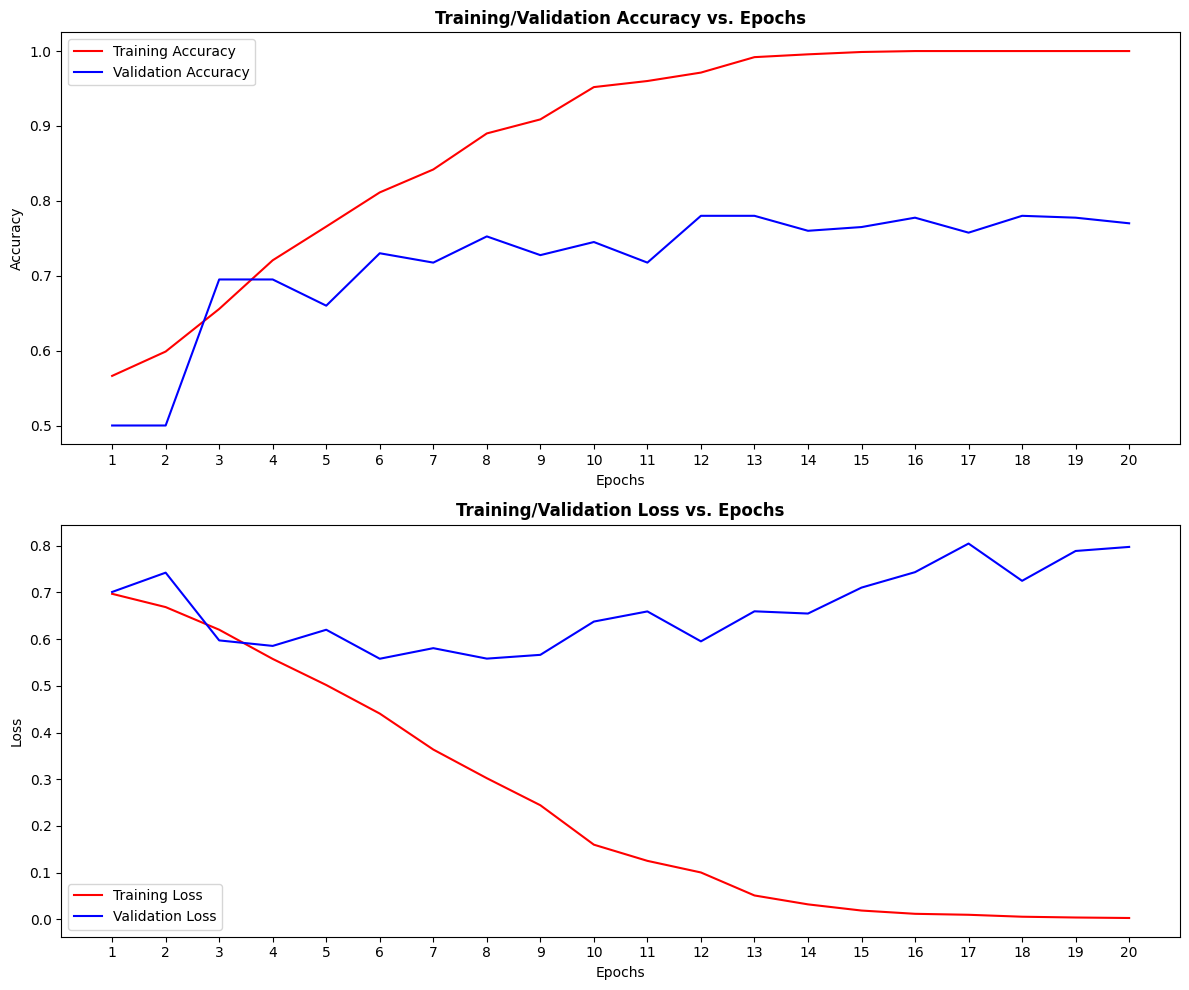

In [6]:
# display plot
plot_acc_loss(history_64_by_64)

Judging from the validation loss curve, it appears the model begins to overfit ~ epoch 8. The validation accuracy reached a peak of .8450 in this model.

Next we will try adding a dropout between each layer with a 25% dropout rate in an attempt to reduce overfitting.

In [7]:
# build CNN with dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25), # add 25% dropout layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # add 25% dropout layer
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.25),  # add 25% dropout layer
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history_64_dropout = model.fit(train_generator, 
                               validation_data=validation_generator, 
                               epochs=20, 
                               verbose=2)

Epoch 1/20
50/50 - 8s - loss: 0.7077 - accuracy: 0.5550 - val_loss: 0.6781 - val_accuracy: 0.5425 - 8s/epoch - 162ms/step
Epoch 2/20
50/50 - 7s - loss: 0.6786 - accuracy: 0.5631 - val_loss: 0.6732 - val_accuracy: 0.6200 - 7s/epoch - 137ms/step
Epoch 3/20
50/50 - 7s - loss: 0.6547 - accuracy: 0.6181 - val_loss: 0.6373 - val_accuracy: 0.6625 - 7s/epoch - 138ms/step
Epoch 4/20
50/50 - 7s - loss: 0.6223 - accuracy: 0.6619 - val_loss: 0.5885 - val_accuracy: 0.7125 - 7s/epoch - 136ms/step
Epoch 5/20
50/50 - 7s - loss: 0.5953 - accuracy: 0.6812 - val_loss: 0.5673 - val_accuracy: 0.7225 - 7s/epoch - 142ms/step
Epoch 6/20
50/50 - 7s - loss: 0.5624 - accuracy: 0.7212 - val_loss: 0.5654 - val_accuracy: 0.7450 - 7s/epoch - 134ms/step
Epoch 7/20
50/50 - 7s - loss: 0.5077 - accuracy: 0.7688 - val_loss: 0.5096 - val_accuracy: 0.7825 - 7s/epoch - 138ms/step
Epoch 8/20
50/50 - 7s - loss: 0.4832 - accuracy: 0.7763 - val_loss: 0.4914 - val_accuracy: 0.8000 - 7s/epoch - 139ms/step
Epoch 9/20
50/50 - 7s - 

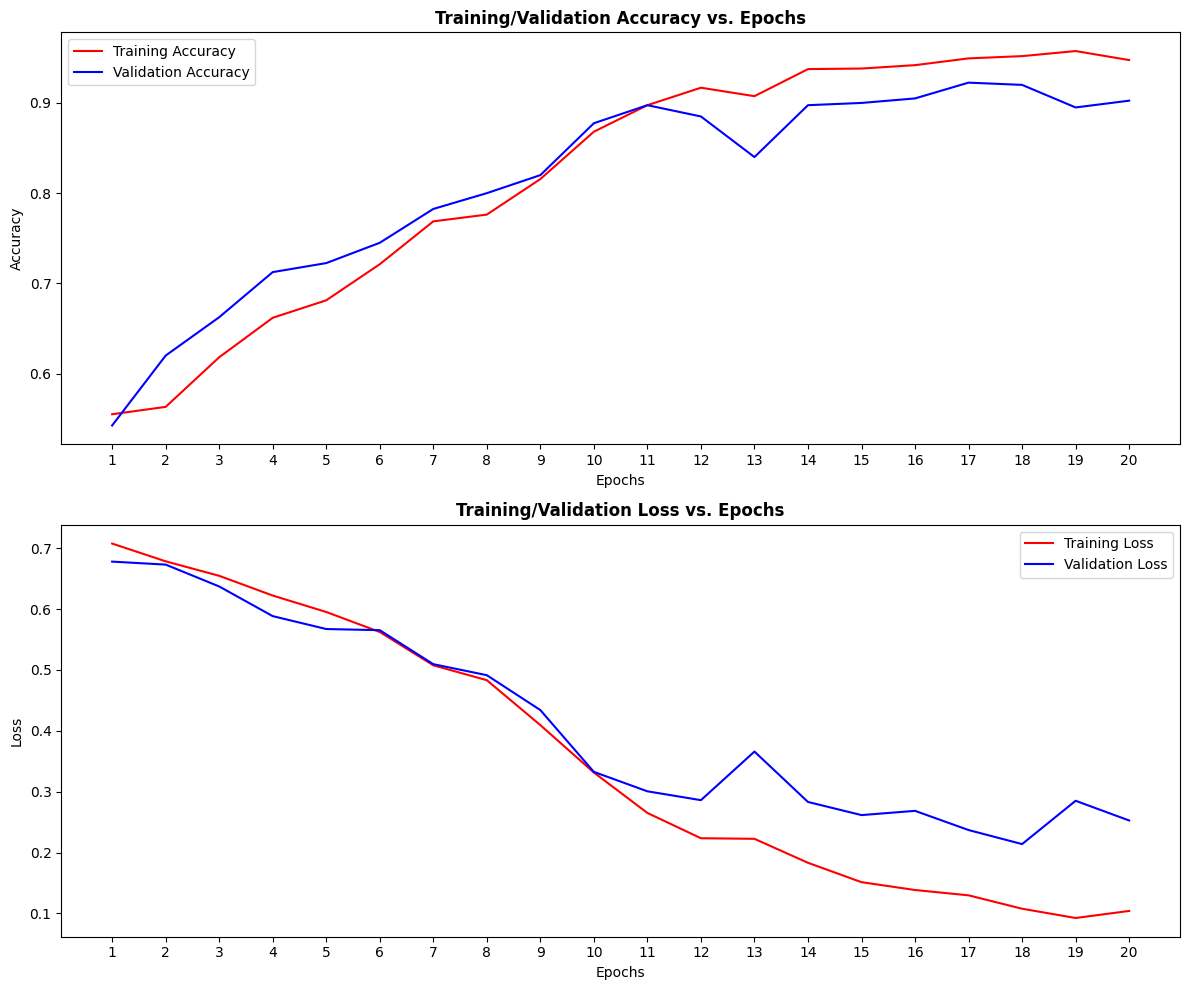

In [8]:
# display plot
plot_acc_loss(history_64_dropout)

Adding the dropout layers appears to have reduced some of the overfitting and improved the accuracy by ~ 5%.

Let's try adding a l2 regularizer to the previous model with l2 = .001 and see if we observe any improvement.

In [9]:
# Define the model with regularization and dropout, l2=.001
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history_64_dropout_l2 = model.fit(train_generator, 
                                  validation_data=validation_generator, 
                                  epochs=20, verbose=2)

Epoch 1/20
50/50 - 9s - loss: 0.9724 - accuracy: 0.5575 - val_loss: 0.8582 - val_accuracy: 0.4900 - 9s/epoch - 186ms/step
Epoch 2/20
50/50 - 7s - loss: 0.8208 - accuracy: 0.5506 - val_loss: 0.8022 - val_accuracy: 0.5450 - 7s/epoch - 145ms/step
Epoch 3/20
50/50 - 7s - loss: 0.7702 - accuracy: 0.6012 - val_loss: 0.7929 - val_accuracy: 0.5300 - 7s/epoch - 146ms/step
Epoch 4/20
50/50 - 7s - loss: 0.7380 - accuracy: 0.6319 - val_loss: 0.7487 - val_accuracy: 0.6000 - 7s/epoch - 145ms/step
Epoch 5/20
50/50 - 7s - loss: 0.7196 - accuracy: 0.6356 - val_loss: 0.7314 - val_accuracy: 0.6075 - 7s/epoch - 147ms/step
Epoch 6/20
50/50 - 7s - loss: 0.6939 - accuracy: 0.6637 - val_loss: 0.7156 - val_accuracy: 0.6100 - 7s/epoch - 143ms/step
Epoch 7/20
50/50 - 8s - loss: 0.6684 - accuracy: 0.6856 - val_loss: 0.7042 - val_accuracy: 0.6475 - 8s/epoch - 153ms/step
Epoch 8/20
50/50 - 7s - loss: 0.6382 - accuracy: 0.7212 - val_loss: 0.6781 - val_accuracy: 0.6750 - 7s/epoch - 146ms/step
Epoch 9/20
50/50 - 7s - 

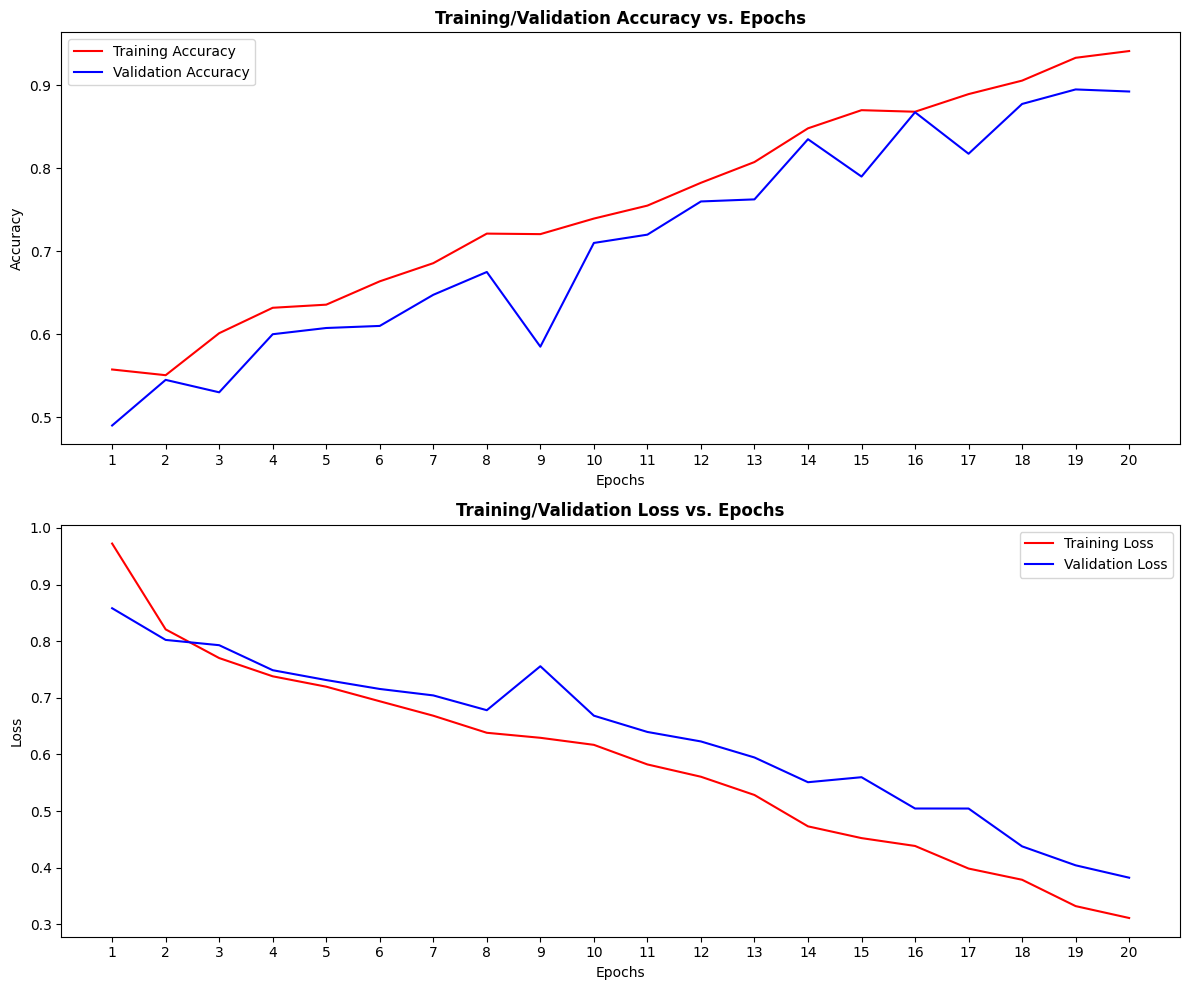

In [10]:
# display plot
plot_acc_loss(history_64_dropout_l2)

Introducing dropout and L2 regularization appeared to improve the model. The validation loss/accuracy curves are more steady and the accuracy reached .90 in the new model. The original model without dropout or l2 regularization had a peak accuracy of .8450 and showed signs of overfitting. Furthermore, the training and validation accuracy of this model are slightly closer to one another by the end of training when compared to the previous model which only had dropout (no l2 regularization). 

Initially, we re-sized the targets to be 64x64. let's try re-sizing the images to 128x128 and compare the validation accuracy to the previous model.

In [11]:
train_generator, validation_generator = create_data_generators(
    base_dir='cell_images_subset', 
    target_size=(128,128), 
    batch_size=32)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [12]:
# build CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the model
history_128_by_128 = model.fit(train_generator, 
                               validation_data=validation_generator, 
                               epochs=20, verbose=2)

Epoch 1/20
50/50 - 22s - loss: 0.8626 - accuracy: 0.5181 - val_loss: 0.6855 - val_accuracy: 0.5275 - 22s/epoch - 432ms/step
Epoch 2/20
50/50 - 21s - loss: 0.6375 - accuracy: 0.6381 - val_loss: 0.6848 - val_accuracy: 0.5625 - 21s/epoch - 420ms/step
Epoch 3/20
50/50 - 20s - loss: 0.5742 - accuracy: 0.7125 - val_loss: 0.5703 - val_accuracy: 0.7450 - 20s/epoch - 394ms/step
Epoch 4/20
50/50 - 19s - loss: 0.4464 - accuracy: 0.8031 - val_loss: 0.6483 - val_accuracy: 0.6700 - 19s/epoch - 386ms/step
Epoch 5/20
50/50 - 19s - loss: 0.2789 - accuracy: 0.8900 - val_loss: 0.6015 - val_accuracy: 0.7325 - 19s/epoch - 387ms/step
Epoch 6/20
50/50 - 19s - loss: 0.1855 - accuracy: 0.9431 - val_loss: 0.6253 - val_accuracy: 0.7325 - 19s/epoch - 381ms/step
Epoch 7/20
50/50 - 19s - loss: 0.0817 - accuracy: 0.9812 - val_loss: 0.8400 - val_accuracy: 0.6875 - 19s/epoch - 381ms/step
Epoch 8/20
50/50 - 20s - loss: 0.0391 - accuracy: 0.9912 - val_loss: 0.8559 - val_accuracy: 0.6925 - 20s/epoch - 393ms/step
Epoch 9/

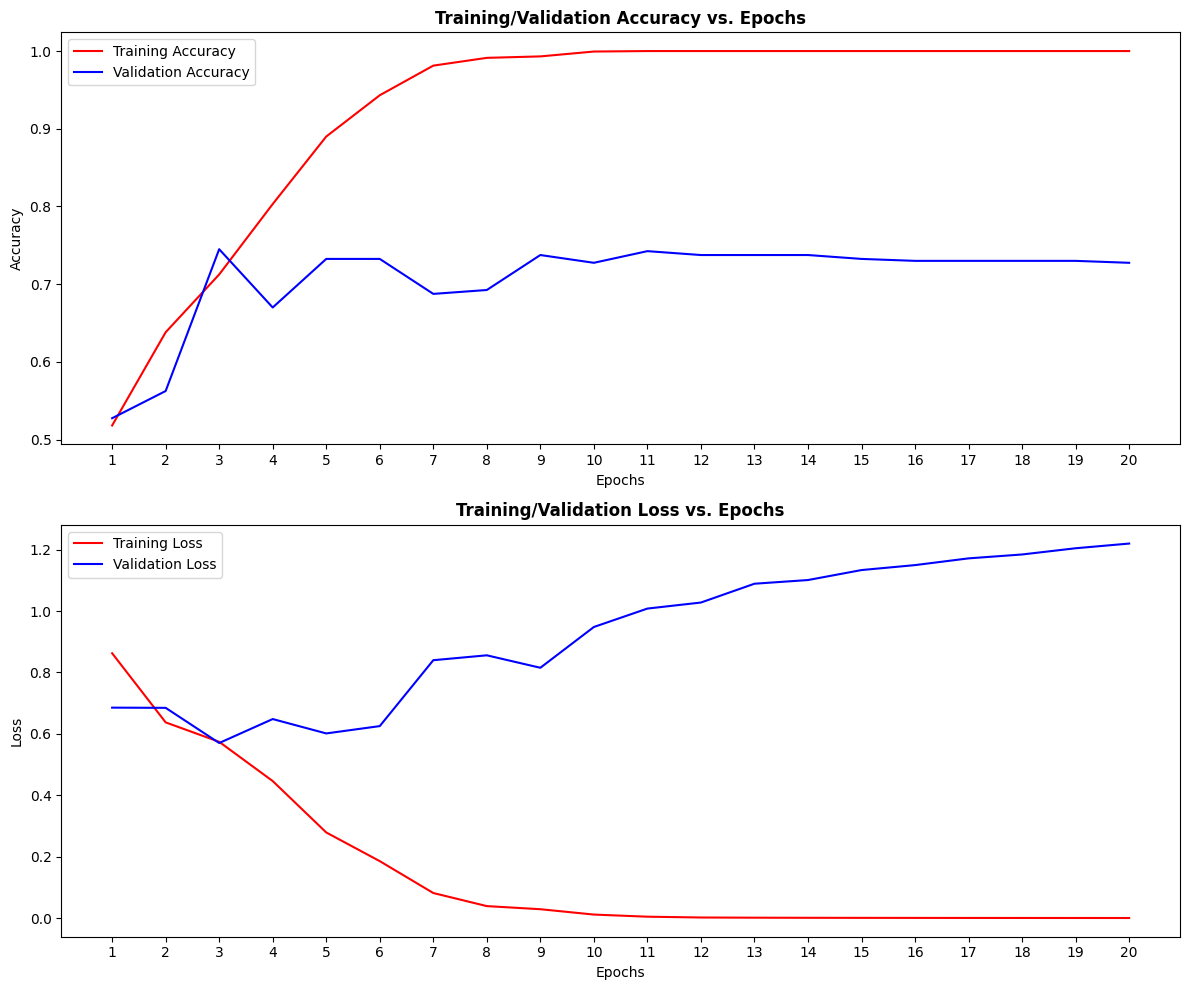

In [13]:
plot_acc_loss(history_128_by_128)

When re-sizing the images to 128x128, the model began to overfit very quickly. The training accuracy climbed to 100% by ~ epoch 10. The vaildation accuracy peaked at 70% and the validation loss steadily rose after epoch 3. 

Thus far, the 64x64 model performed better, and required significantly less compute time. 

Next we will try introducing regularization and dropout in an attempt to mitigate overfitting in the 128x128 model.

In [14]:
# Define the model with regularization and dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_128_l2_dropout = model.fit(train_generator, 
                                   validation_data=validation_generator, 
                                   epochs=20)

Epoch 1/20
50/50 [==============================] - 26s 482ms/step - loss: 1.2382 - accuracy: 0.5094 - val_loss: 0.9004 - val_accuracy: 0.5825
Epoch 2/20
50/50 [==============================] - 25s 508ms/step - loss: 0.8433 - accuracy: 0.5969 - val_loss: 0.8298 - val_accuracy: 0.5500
Epoch 3/20
50/50 [==============================] - 23s 468ms/step - loss: 0.7824 - accuracy: 0.6275 - val_loss: 0.7792 - val_accuracy: 0.6400
Epoch 4/20
50/50 [==============================] - 24s 486ms/step - loss: 0.7531 - accuracy: 0.6331 - val_loss: 0.7827 - val_accuracy: 0.5525
Epoch 5/20
50/50 [==============================] - 24s 483ms/step - loss: 0.7275 - accuracy: 0.6500 - val_loss: 0.7762 - val_accuracy: 0.5625
Epoch 6/20
50/50 [==============================] - 25s 490ms/step - loss: 0.6970 - accuracy: 0.6862 - val_loss: 0.7119 - val_accuracy: 0.6800
Epoch 7/20
50/50 [==============================] - 25s 495ms/step - loss: 0.6464 - accuracy: 0.7231 - val_loss: 0.6892 - val_accuracy: 0.7200

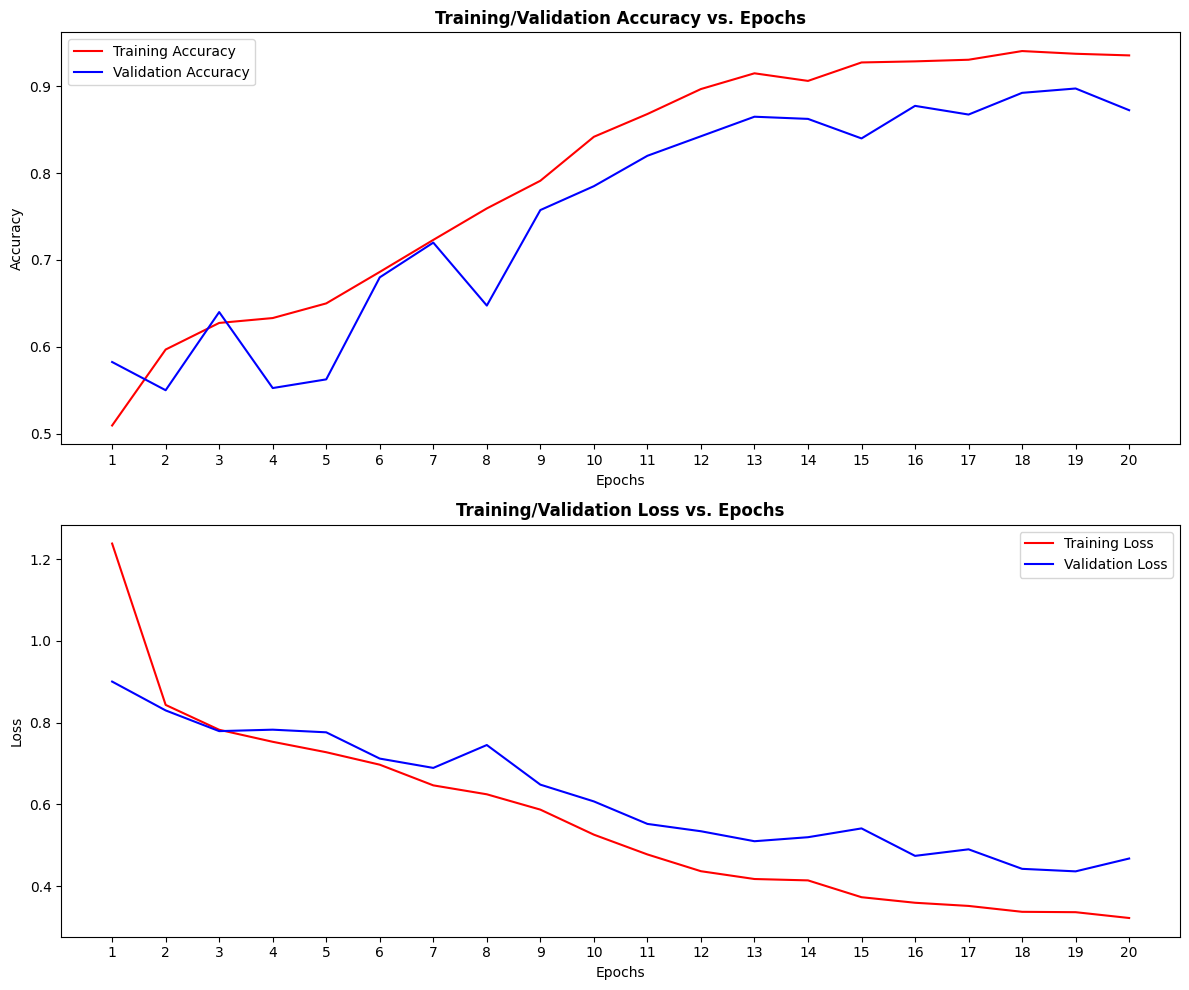

In [15]:
plot_acc_loss(history_128_l2_dropout)

The introduction of dropout and l2 regularization significantly mitigated the amount of overfitting in the model. We achieved a validation accuracy of almost 90%, which is a significant improvement over the previous model.

Next we can try increasing the complexity of the model by adding more convolutional layers and increasing the number of filters. We will also introduce data augmentation which can help mitigate the increased risk of overfitting that arises from using a more complex model.

Model with increased complexity:
1. Additional Convolutional Layer with 128 filters
2. Additional Dropout Layer with rate of .5 
3. Additional Dense Layer with 64 neurons

In [16]:
# create generators with augmentation
train_generator, validation_generator = create_data_generators(
    base_dir='cell_images_subset', 
    target_size=(128,128), 
    batch_size=32, 
    augmentation=True)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [17]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_complex = model.fit(train_generator, 
                            validation_data=validation_generator, 
                            epochs=20, 
                            verbose=2)

Epoch 1/20
50/50 - 31s - loss: 0.7016 - accuracy: 0.4994 - val_loss: 0.6927 - val_accuracy: 0.5000 - 31s/epoch - 623ms/step
Epoch 2/20
50/50 - 29s - loss: 0.6918 - accuracy: 0.5288 - val_loss: 0.6888 - val_accuracy: 0.5050 - 29s/epoch - 572ms/step
Epoch 3/20
50/50 - 31s - loss: 0.6819 - accuracy: 0.5706 - val_loss: 0.7003 - val_accuracy: 0.5025 - 31s/epoch - 612ms/step
Epoch 4/20
50/50 - 32s - loss: 0.6774 - accuracy: 0.6350 - val_loss: 0.6368 - val_accuracy: 0.6975 - 32s/epoch - 634ms/step
Epoch 5/20
50/50 - 31s - loss: 0.6334 - accuracy: 0.6612 - val_loss: 0.4408 - val_accuracy: 0.8350 - 31s/epoch - 621ms/step
Epoch 6/20
50/50 - 30s - loss: 0.5463 - accuracy: 0.7725 - val_loss: 0.4367 - val_accuracy: 0.7975 - 30s/epoch - 598ms/step
Epoch 7/20
50/50 - 31s - loss: 0.5075 - accuracy: 0.8087 - val_loss: 0.5722 - val_accuracy: 0.6875 - 31s/epoch - 611ms/step
Epoch 8/20
50/50 - 31s - loss: 0.5355 - accuracy: 0.7638 - val_loss: 0.3361 - val_accuracy: 0.9050 - 31s/epoch - 621ms/step
Epoch 9/

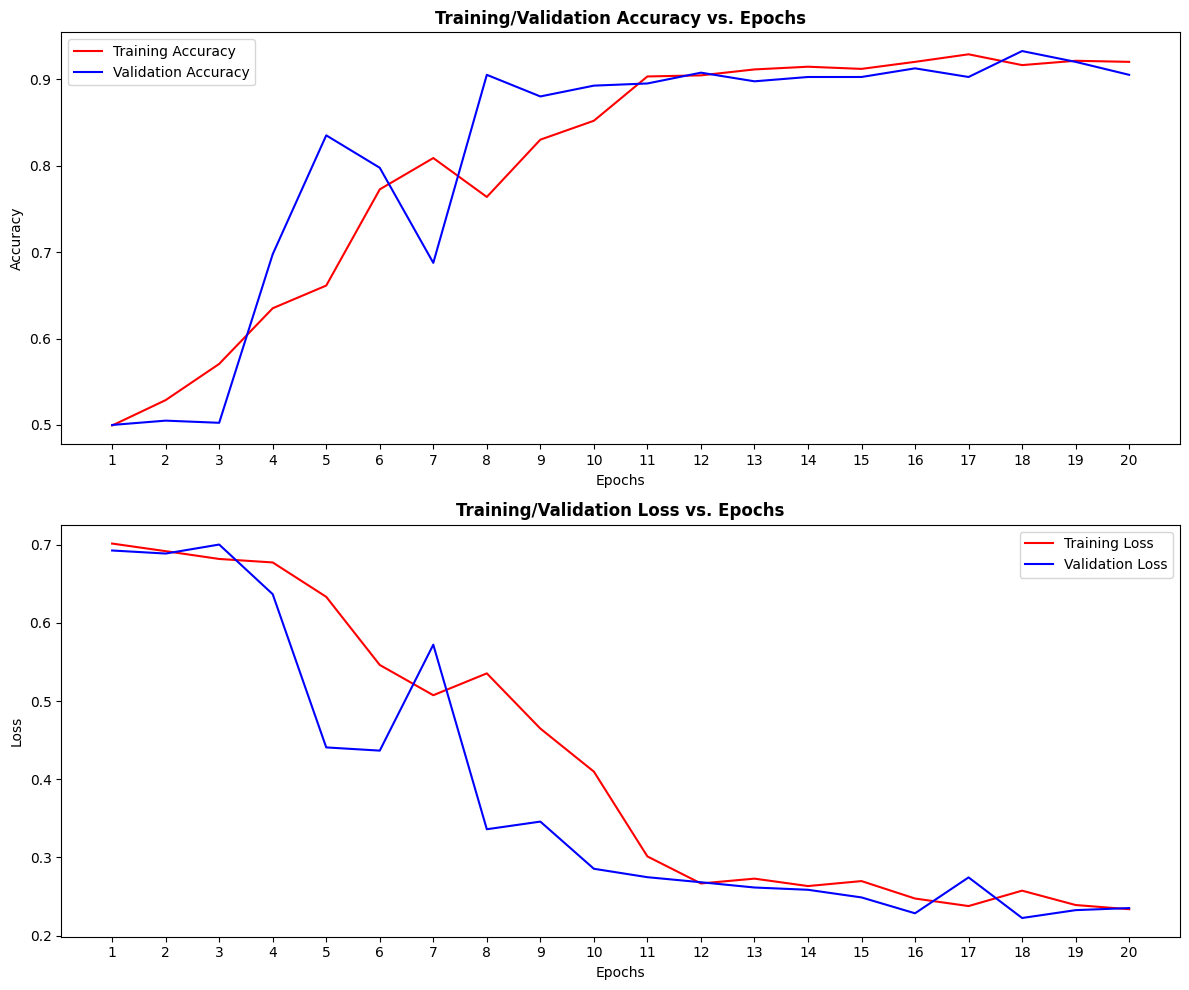

In [18]:
plot_acc_loss(history_complex)

This Model achieved the highest validation accuracy we have seen thus far with a peak of .90. However, the validation curves are rather sporadic. Let's try introducing batch normalization into more complex model in an attempt to stabilize the learning process and smoothen our validation curves.

In [19]:
# Define the CNN model with Batch Normalization and L2 Regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(), # adding batch normalization between layers
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # adding batch normalization between layers
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # adding batch normalization between layers
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # adding batch normalization between layers
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(), # adding batch normalization between layers
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with augmented data
history_complex_bn = model.fit(train_generator, validation_data=validation_generator, epochs=20, verbose=2)

Epoch 1/20
50/50 - 42s - loss: 1.5280 - accuracy: 0.5494 - val_loss: 1.2854 - val_accuracy: 0.5500 - 42s/epoch - 841ms/step
Epoch 2/20
50/50 - 38s - loss: 1.4524 - accuracy: 0.5713 - val_loss: 1.6076 - val_accuracy: 0.5000 - 38s/epoch - 755ms/step
Epoch 3/20
50/50 - 38s - loss: 1.4134 - accuracy: 0.5756 - val_loss: 1.5172 - val_accuracy: 0.5025 - 38s/epoch - 765ms/step
Epoch 4/20
50/50 - 39s - loss: 1.3950 - accuracy: 0.5694 - val_loss: 1.3606 - val_accuracy: 0.5975 - 39s/epoch - 790ms/step
Epoch 5/20
50/50 - 41s - loss: 1.3606 - accuracy: 0.5700 - val_loss: 1.3629 - val_accuracy: 0.5025 - 41s/epoch - 817ms/step
Epoch 6/20
50/50 - 39s - loss: 1.3388 - accuracy: 0.5744 - val_loss: 1.3146 - val_accuracy: 0.5025 - 39s/epoch - 780ms/step
Epoch 7/20
50/50 - 38s - loss: 1.3060 - accuracy: 0.5850 - val_loss: 1.3205 - val_accuracy: 0.5000 - 38s/epoch - 767ms/step
Epoch 8/20
50/50 - 40s - loss: 1.2821 - accuracy: 0.5669 - val_loss: 1.2482 - val_accuracy: 0.5100 - 40s/epoch - 802ms/step
Epoch 9/

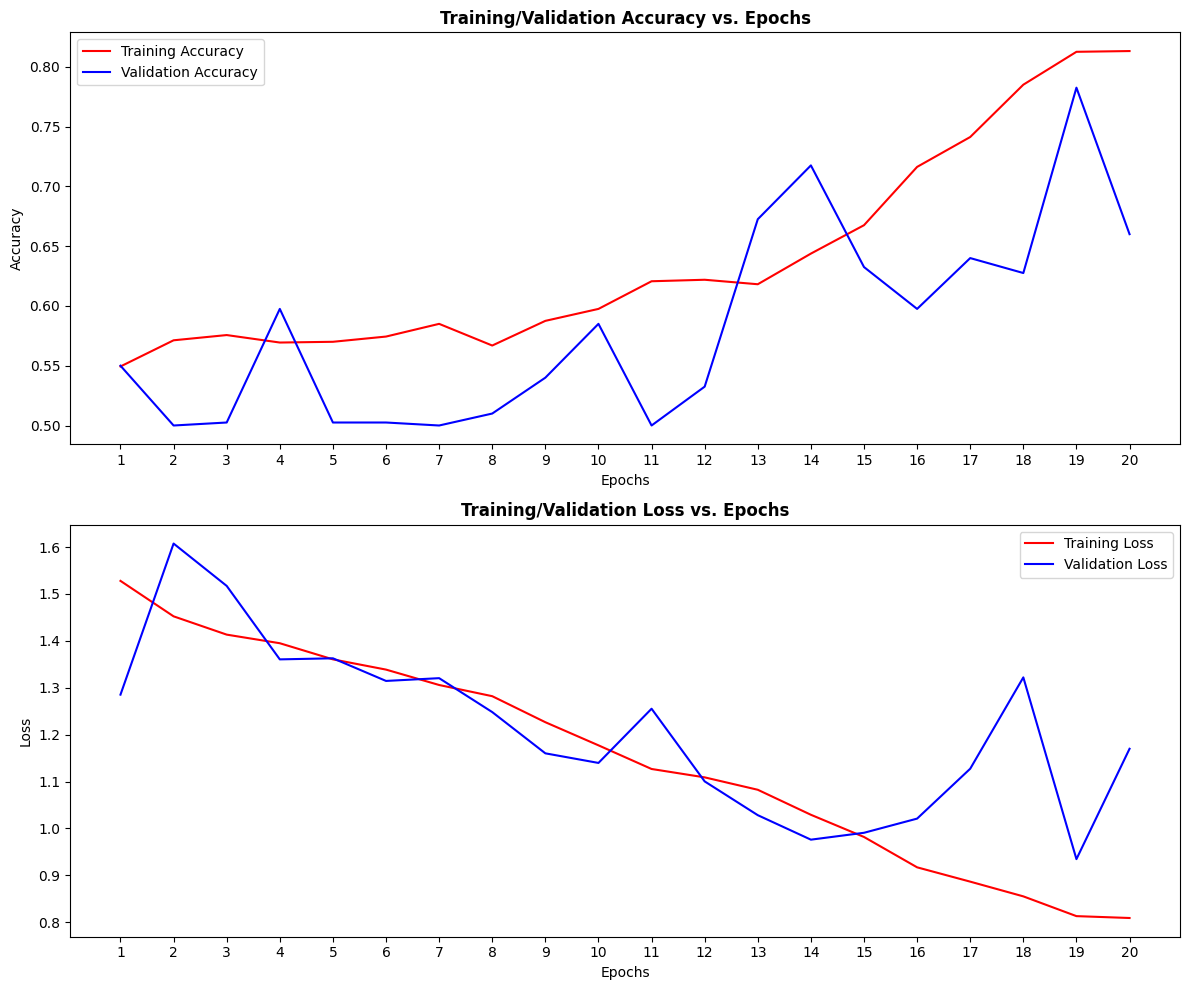

In [20]:
plot_acc_loss(history_complex_bn)

This introduction of batch normalization appeared to make our validation curves more sporadic. It is possible that a batch size of 32 was not large enough to output relatively consistent means and variances for each batch. If there is a large disparity between the computed statistics of each batch, training can be destabilized and negatively affect model performance. When we train on the entire dataset, we will use a larger batch size and perhaps batch normalization will be more effective.

We will continue to build off of this model in attempt to continue improving its performance. 

Our next model will implement early stopping and a learning rate scheduler. For our learning rate scheduler, we will use the keras callback method 'ReduceLROnPlateau'. This method will reduces the learning rate when a specified metric - in this case validation loss - stops improving for a specified number of epochs.

In [21]:
# Add Early stopping and learning rate scheduler to the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Callbacks for learning rate adjustment, early stopping, and model checkpoint
callbacks = [
    ModelCheckpoint('best_model_v1.h5', 
                    save_best_only=True, 
                    monitor='val_accuracy'),
    ReduceLROnPlateau(monitor='val_accuracy', 
                      factor=0.5, 
                      patience=3, 
                      min_lr=1e-6)
]

# Train the model with augmented data, increase epochs to 30 now that we have implemented early stopping
history_complex_lr_sched = model.fit(train_generator, 
                                     validation_data=validation_generator, 
                                     callbacks=callbacks,
                                     epochs=30, 
                                     verbose=2)


Epoch 1/30
50/50 - 43s - loss: 1.4778 - accuracy: 0.5481 - val_loss: 1.7061 - val_accuracy: 0.5000 - lr: 0.0010 - 43s/epoch - 861ms/step


C:\Users\gdgun\COMP4531\my_tensorflow_project\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
50/50 - 41s - loss: 1.4758 - accuracy: 0.5331 - val_loss: 2.5829 - val_accuracy: 0.5000 - lr: 0.0010 - 41s/epoch - 816ms/step
Epoch 3/30
50/50 - 42s - loss: 1.4359 - accuracy: 0.5600 - val_loss: 1.3710 - val_accuracy: 0.5000 - lr: 0.0010 - 42s/epoch - 850ms/step
Epoch 4/30
50/50 - 41s - loss: 1.3799 - accuracy: 0.5725 - val_loss: 1.8115 - val_accuracy: 0.5000 - lr: 0.0010 - 41s/epoch - 830ms/step
Epoch 5/30
50/50 - 41s - loss: 1.3210 - accuracy: 0.5881 - val_loss: 1.6001 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 41s/epoch - 829ms/step
Epoch 6/30
50/50 - 41s - loss: 1.3235 - accuracy: 0.5819 - val_loss: 1.5474 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 41s/epoch - 814ms/step
Epoch 7/30
50/50 - 41s - loss: 1.2751 - accuracy: 0.5781 - val_loss: 1.8538 - val_accuracy: 0.5000 - lr: 5.0000e-04 - 41s/epoch - 812ms/step
Epoch 8/30
50/50 - 39s - loss: 1.2714 - accuracy: 0.5806 - val_loss: 1.3602 - val_accuracy: 0.5200 - lr: 2.5000e-04 - 39s/epoch - 780ms/step
Epoch 9/30
50/50 - 41s - 

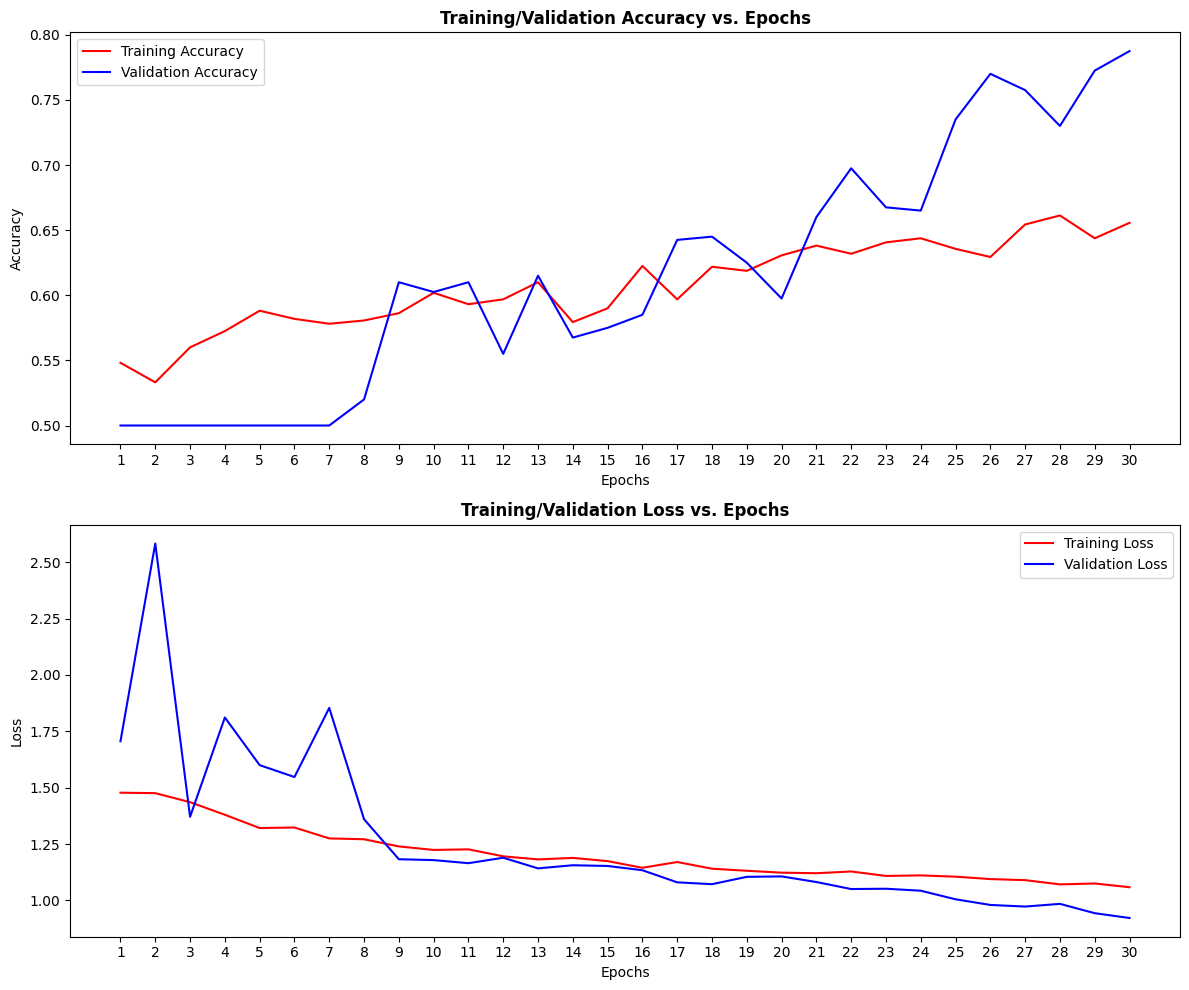

In [22]:
plot_acc_loss(history_complex_lr_sched)

This model showed a steady increase in the validation accuracy up until ~ epoch 17. After that there were steep drops and spikes in both the validation accuracy and loss curves.

Let's try using one of the better-performing models from earlier and modify the target_size to 64x64. 

In [23]:
# re-define targets to be 64x64
train_generator, validation_generator = create_data_generators(base_dir='cell_images_subset', target_size=(64,64), batch_size=32, augmentation=True)

# Define the CNN model with Batch Normalization and L2 Regularization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping, and model checkpoint
callbacks = [
    ModelCheckpoint('best_model_v2.h5', 
                    save_best_only=True, 
                    monitor='val_accuracy')
]
  

# Train the model with augmented data
history_complex_64 = model.fit(train_generator, 
                               validation_data=validation_generator, 
                               callbacks=callbacks,
                               epochs=30, 
                               verbose=2)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/30
50/50 - 16s - loss: 1.4069 - accuracy: 0.5450 - val_loss: 1.1944 - val_accuracy: 0.5000 - 16s/epoch - 321ms/step
Epoch 2/30
50/50 - 12s - loss: 1.3290 - accuracy: 0.5725 - val_loss: 1.1931 - val_accuracy: 0.5000 - 12s/epoch - 242ms/step
Epoch 3/30
50/50 - 12s - loss: 1.2849 - accuracy: 0.5694 - val_loss: 1.2896 - val_accuracy: 0.5000 - 12s/epoch - 245ms/step
Epoch 4/30
50/50 - 12s - loss: 1.2584 - accuracy: 0.5819 - val_loss: 1.1747 - val_accuracy: 0.5275 - 12s/epoch - 244ms/step
Epoch 5/30
50/50 - 12s - loss: 1.2501 - accuracy: 0.5763 - val_loss: 1.2008 - val_accuracy: 0.5000 - 12s/epoch - 247ms/step
Epoch 6/30
50/50 - 12s - loss: 1.1990 - accuracy: 0.5838 - val_loss: 1.1640 - val_accuracy: 0.5025 - 12s/epoch - 247ms/step
Epoch 7/30
50/50 - 13s - loss: 1.1854 - accuracy: 0.5913 - val_loss: 1.1435 - val_accuracy: 0.5450 - 13s/epoch - 251ms/step
Epoch 8/30
50/50 - 13s - loss: 1.1608 - accuracy:

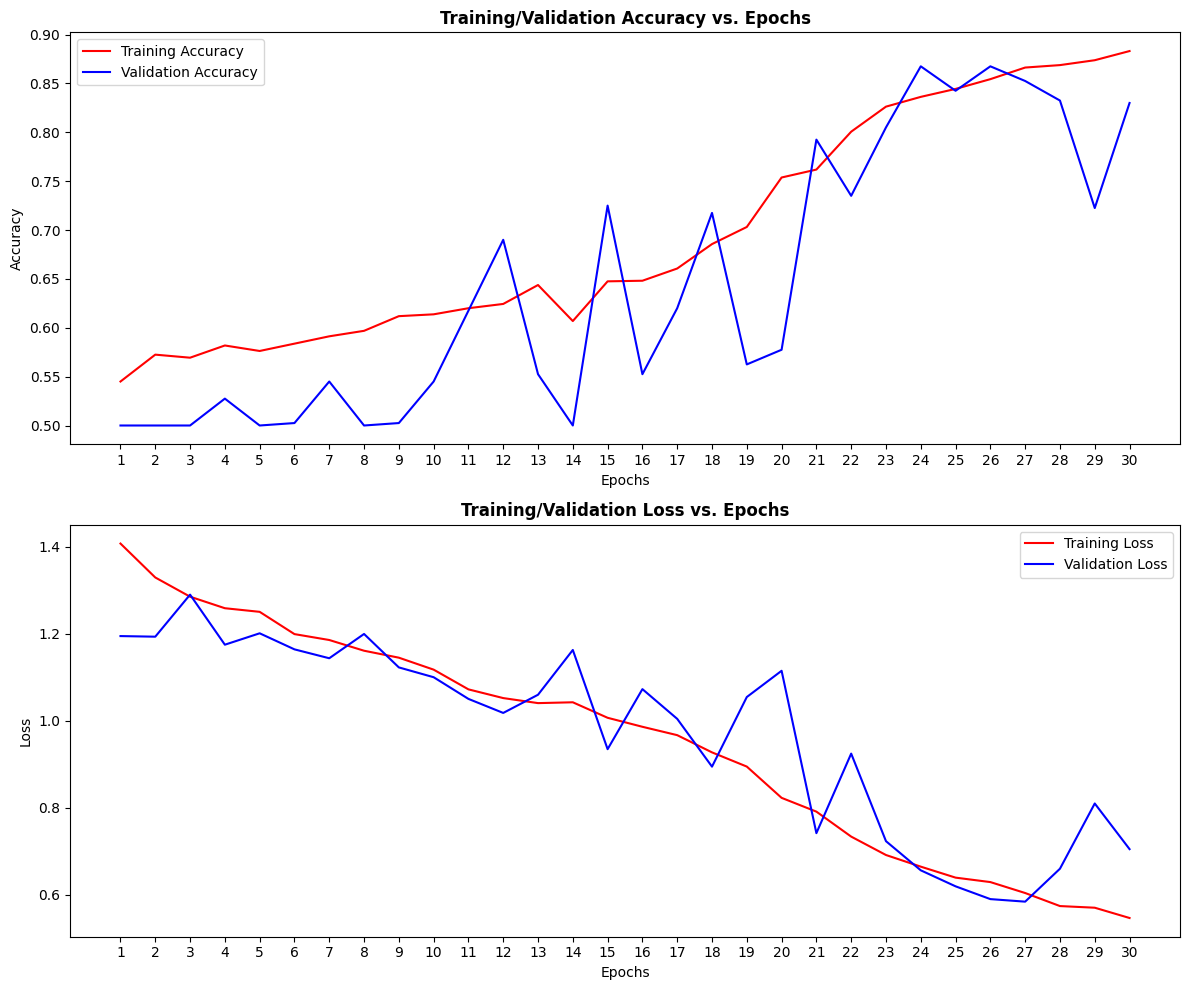

In [24]:
plot_acc_loss(history_complex_64)

This model performed similarly to the model with the similar structure that used target_size = 128x128. The validation curves were especially also unpredictable. It was not the best performing model that used 64x64 target sizes.

Now that we have run a number of different models on a subset of the data, we have narrowed down some different model structures that have performed well on the subset. We will now test a few of the higher-performing models on the whole data set. We will leverage the entirety of the dataset to build our best model (all 27,560 images). 

In the code below, we will split the data into three separate directories. 70% of the data will be allocated for training, 20% for validation, and 10% for testing. 

In [25]:
import os
import shutil
import random

# Specify the original directories
original_dir = 'cell_images/cell_images'

# Specify the directories for the split
train_dir = 'cell_images/train'
val_dir = 'cell_images/validation'
test_dir = 'cell_images/test'

# Ensure the directories exist
for dir_path in [train_dir, val_dir, test_dir]:
    if not os.path.exists(dir_path):
        os.makedirs(os.path.join(dir_path, 'Parasitized'))
        os.makedirs(os.path.join(dir_path, 'Uninfected'))

# Specify the categories
categories = ['Parasitized', 'Uninfected']

# make sure directories are not overwritten if they already exist(for when I re-run)
def ensure_directory_contents(dir_path, category, files):
    category_dir = os.path.join(dir_path, category)
    if not os.listdir(category_dir):  # Check if the directory is empty
        for file in files:
            shutil.copy(os.path.join(original_dir, category, file), os.path.join(category_dir, file))


# Splitting images into 70% training, 20% validation, 10% testing
for category in categories:
    # list files
    files = os.listdir(os.path.join(original_dir, category))
    
    # suffle files
    random.shuffle(files)
    
    # compute splits
    train_size = int(0.7 * len(files))
    val_size = int(0.2 * len(files))
    
    # split
    train_files = files[:train_size]
    val_files = files[train_size:train_size+val_size]
    test_files = files[train_size+val_size:]
    
    # Only copy files if directories are empty
    ensure_directory_contents(train_dir, category, train_files)
    ensure_directory_contents(val_dir, category, val_files)
    ensure_directory_contents(test_dir, category, test_files)

In [26]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tabulate import tabulate 

In [27]:
# new data generator function
def create_data_generators_wholeset(base_dir, target_size, batch_size=128, augmentation=False):
    
    # Define class mapping
    class_indices = {'Uninfected': 0, 'Parasitized': 1} 
    
    if augmentation:  # Create data generator with augmentation for training
        train_datagen = ImageDataGenerator(
            rescale=1.0/255.0,
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    else:  # Standard rescaling generator for training
        train_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # For validation and test, always use the same datagen without augmentation
    test_val_datagen = ImageDataGenerator(rescale=1.0/255.0)
    
    # Training data
    train_generator = train_datagen.flow_from_directory(
        directory=f'{base_dir}/train',
        target_size=target_size,  # Taken from function args
        batch_size=batch_size,  # Taken from function args
        class_mode='binary',
        shuffle=True,  # Shuffle for training data
        classes=list(class_indices.keys())  # Use pre-defined class mapping
    )

    # Validation data
    validation_generator = test_val_datagen.flow_from_directory(
        directory=f'{base_dir}/validation',
        target_size=target_size,  # Taken from function args
        batch_size=batch_size,  # Taken from function args
        class_mode='binary',
        shuffle=False,  # No shuffling for validation data
        classes=list(class_indices.keys())  # Use pre-defined class mapping
    )
    
    # Test data
    test_generator = test_val_datagen.flow_from_directory(
        directory=f'{base_dir}/test',
        target_size=target_size,  # Taken from function args
        batch_size=batch_size,  # Taken from function args
        class_mode='binary', 
        shuffle=False,  # No shuffling for test data
        classes=list(class_indices.keys())  # Use pre-defined class mapping
    )
    
    return train_generator, validation_generator, test_generator


We will select 4 models to re-train on the entirety of the dataset. When training with the entire data_set we will use larger batch_sizes (128 or 256 depending on the model).

MODEL 1 DETAILS
Target Size: 64x64
Batch Size: 128
No Data Augmentation
2 Convolutional Layers 
2 Dense Layers
25% Dropout between each layer 
L2 regularization = .001 for each layer (except output layer)

In [28]:
# Simple model with 64x64 targets initially, higher batch_size
train_generator, validation_generator, test_generator = create_data_generators_wholeset(
    base_dir='cell_images',
    target_size=(64,64), 
    batch_size=128,
    augmentation=False
)

# Define the model with regularization and dropout
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks=[ModelCheckpoint('best_model_wholeset_v1.h5', 
                           save_best_only=True, 
                           monitor='val_accuracy')]

# Training the model
history_64_whole_set = model.fit(train_generator, 
                                 validation_data=validation_generator, 
                                 callbacks=callbacks, 
                                 epochs=30, 
                                 verbose=2)

Found 19291 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Epoch 1/30
151/151 - 75s - loss: 0.8127 - accuracy: 0.5672 - val_loss: 0.7066 - val_accuracy: 0.6355 - 75s/epoch - 494ms/step
Epoch 2/30
151/151 - 72s - loss: 0.6560 - accuracy: 0.6830 - val_loss: 0.6190 - val_accuracy: 0.7146 - 72s/epoch - 478ms/step
Epoch 3/30
151/151 - 73s - loss: 0.5643 - accuracy: 0.7698 - val_loss: 0.4570 - val_accuracy: 0.8363 - 73s/epoch - 482ms/step
Epoch 4/30
151/151 - 73s - loss: 0.4093 - accuracy: 0.8771 - val_loss: 0.3443 - val_accuracy: 0.9116 - 73s/epoch - 486ms/step
Epoch 5/30
151/151 - 74s - loss: 0.3536 - accuracy: 0.9031 - val_loss: 0.3125 - val_accuracy: 0.9151 - 74s/epoch - 487ms/step
Epoch 6/30
151/151 - 73s - loss: 0.3287 - accuracy: 0.9096 - val_loss: 0.2907 - val_accuracy: 0.9191 - 73s/epoch - 484ms/step
Epoch 7/30
151/151 - 72s - loss: 0.3177 - accuracy: 0.9139 - val_loss: 0.2883 - val_accuracy: 0.9234 - 72s/epoch - 47

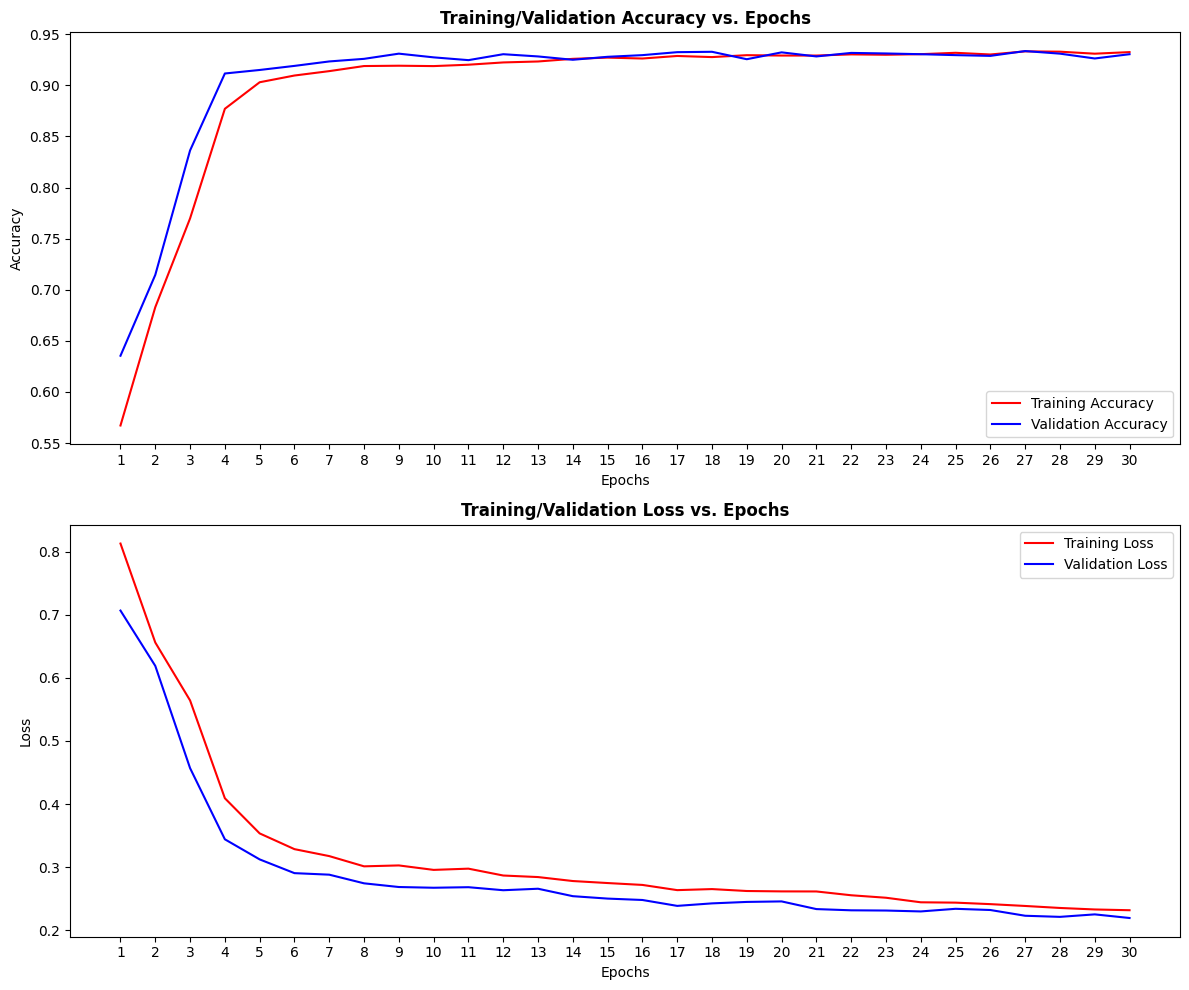

In [29]:
# display plot
plot_acc_loss(history_64_whole_set)

Now we will evaluate the model and make predictions with the model trained on the entire data set.

Initially when I did this step, the accuracy for the predictions was 50%, even though the test accuracy reported by my model.evaluate function was > 90% for each of the models. Originally, when I created my test generator, I did not specify shuffle = False. The indices of predicted labels that I was applying to the unseen test data did not match. This led to obtaining the same accuracy that would result for random predictions. 

After specifying shuffle = False in the create_data_generators_wholeset() function, the accuracy that resulted from the predictions aligned with that of the model.evaluate() function. 

In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tabulate import tabulate 

# Load the best model
best_model_path1 = 'best_model_wholeset_v1.h5'
best_model1 = load_model(best_model_path1)

# Evaluate the model on the test data
test_loss1, test_accuracy1 = best_model1.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss1:.4f}, Test Accuracy: {test_accuracy1:.4f}")

# Make predictions
predictions1 = best_model1.predict(test_generator)
predicted_labels1 = np.round(predictions1).flatten()

# True labels
true_labels1 = test_generator.classes

# check how classes are labeled, before changing 0s and 1s labels
class_indices = test_generator.class_indices
print(f"\nClass Indices: {class_indices}\n")

# Confusion matrix and classification report
cm1 = confusion_matrix(true_labels1, predicted_labels1)
print(f"\nConfusion Matrix:\n{cm1}")

report1 = classification_report(true_labels1, predicted_labels1, 
                                target_names=['Uninfected', 'Malaria'])
print("\nClassification Report:\n", report1)

Test Loss: 0.2177, Test Accuracy: 0.9340
22/22 [==============================] - 5s 216ms/step

Class Indices: {'Uninfected': 0, 'Parasitized': 1}


Confusion Matrix:
[[1263  115]
 [  67 1311]]

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.95      0.92      0.93      1378
     Malaria       0.92      0.95      0.94      1378

    accuracy                           0.93      2756
   macro avg       0.93      0.93      0.93      2756
weighted avg       0.93      0.93      0.93      2756



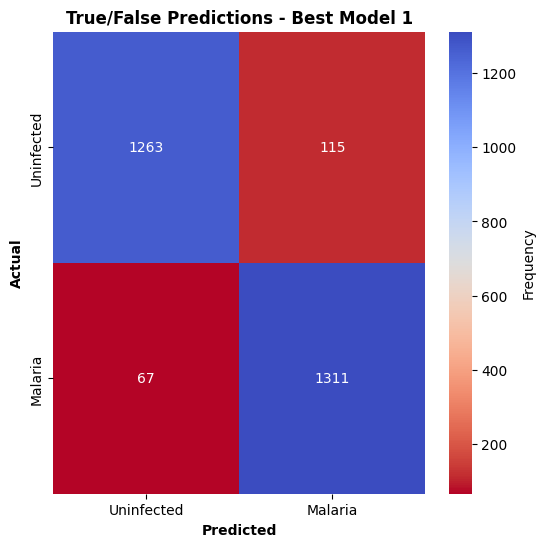

In [31]:
# Plot confusion matrix using seaborn to see labels
plt.figure(figsize=(6, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='coolwarm_r',
            xticklabels=['Uninfected', 'Malaria'], yticklabels=['Uninfected', 'Malaria'],
            cbar_kws={'label': 'Frequency'})
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('True/False Predictions - Best Model 1', fontweight='bold')
plt.show()

MODEL 2 DETAILS
Target Size: 128x128
Batch Size: 128
No Data Augmentation
2 Convolutional Layers 
2 Dense Layers
25% Dropout after each convolutional layer, 50% Dropout before output layer 
L2 regularization = .001 between each layer

In [32]:
# with 128x128 targets, dropout, l2 regularization, higher batch_size
train_generator, validation_generator, test_generator = create_data_generators_wholeset(
    base_dir='cell_images',
    target_size=(128,128), 
    batch_size=128, 
    augmentation=False
)

# Define the model with regularization and dropout that performed well on subset
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks=[
    EarlyStopping(monitor='val_accuracy', 
                  patience=8, 
                  restore_best_weights=True),
    ModelCheckpoint('best_model_wholeset_v2.h5', 
                    save_best_only=True, 
                    monitor='val_accuracy')
]

history_128_l2_dropout_wholeset = model.fit(train_generator, 
                                            validation_data=validation_generator, 
                                            callbacks=callbacks,
                                            epochs=30, 
                                            verbose=2)

Found 19291 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Epoch 1/30


C:\Users\gdgun\COMP4531\my_tensorflow_project\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


151/151 - 245s - loss: 0.8589 - accuracy: 0.6249 - val_loss: 0.6947 - val_accuracy: 0.6864 - 245s/epoch - 2s/step
Epoch 2/30
151/151 - 243s - loss: 0.5650 - accuracy: 0.8051 - val_loss: 0.4215 - val_accuracy: 0.9078 - 243s/epoch - 2s/step
Epoch 3/30
151/151 - 240s - loss: 0.4104 - accuracy: 0.8988 - val_loss: 0.3553 - val_accuracy: 0.9222 - 240s/epoch - 2s/step
Epoch 4/30
151/151 - 240s - loss: 0.3619 - accuracy: 0.9144 - val_loss: 0.3150 - val_accuracy: 0.9252 - 240s/epoch - 2s/step
Epoch 5/30
151/151 - 237s - loss: 0.3376 - accuracy: 0.9193 - val_loss: 0.3022 - val_accuracy: 0.9160 - 237s/epoch - 2s/step
Epoch 6/30
151/151 - 241s - loss: 0.3217 - accuracy: 0.9231 - val_loss: 0.2919 - val_accuracy: 0.9169 - 241s/epoch - 2s/step
Epoch 7/30
151/151 - 240s - loss: 0.3092 - accuracy: 0.9276 - val_loss: 0.2774 - val_accuracy: 0.9218 - 240s/epoch - 2s/step
Epoch 8/30
151/151 - 238s - loss: 0.3029 - accuracy: 0.9282 - val_loss: 0.2832 - val_accuracy: 0.9231 - 238s/epoch - 2s/step
Epoch 9/30


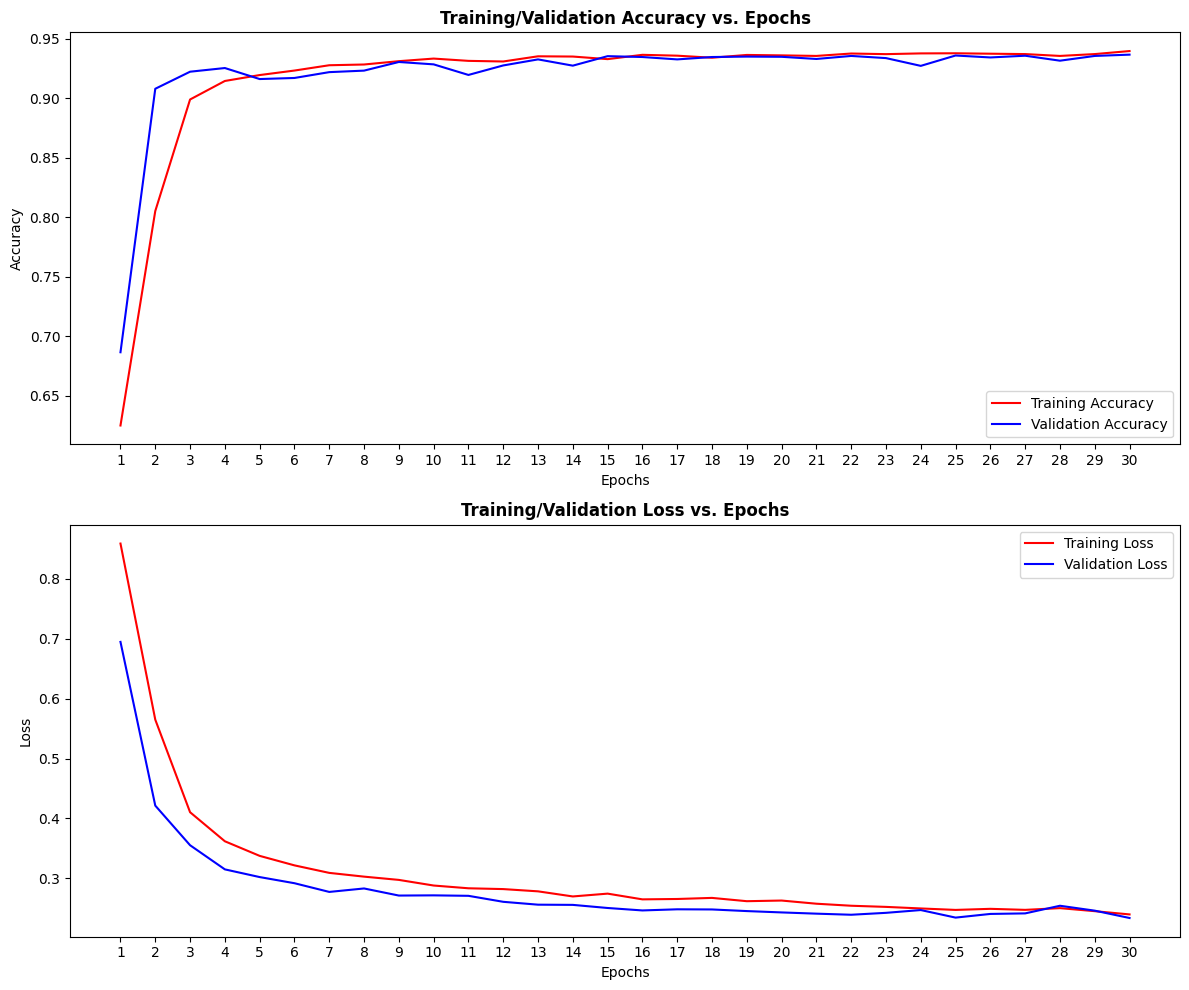

In [33]:
# display plot
plot_acc_loss(history_128_l2_dropout_wholeset)

In [34]:
# Load the best model
best_model_path2 = 'best_model_wholeset_v2.h5'
best_model2 = load_model(best_model_path2)

# Evaluate the model on the test data
test_loss2, test_accuracy2 = best_model2.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss2:.4f}, Test Accuracy: {test_accuracy2:.4f}")

# Make predictions
predictions2 = best_model2.predict(test_generator)
predicted_labels2 = np.round(predictions2).flatten()

# True labels
true_labels2 = test_generator.classes

# check how classes are labeled, before changing 0s and 1s labels
class_indices = test_generator.class_indices
print(f"\nClass Indices: {class_indices}\n")

# Confusion matrix and classification report
cm2 = confusion_matrix(true_labels2, predicted_labels2)
print(f"\nConfusion Matrix:\n{cm2}")

report2 = classification_report(true_labels2, predicted_labels2, 
                                target_names=['Uninfected', 'Malaria'])
print("\nClassification Report:\n", report2)

Test Loss: 0.2303, Test Accuracy: 0.9409
22/22 [==============================] - 9s 378ms/step

Class Indices: {'Uninfected': 0, 'Parasitized': 1}


Confusion Matrix:
[[1271  107]
 [  56 1322]]

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.96      0.92      0.94      1378
     Malaria       0.93      0.96      0.94      1378

    accuracy                           0.94      2756
   macro avg       0.94      0.94      0.94      2756
weighted avg       0.94      0.94      0.94      2756



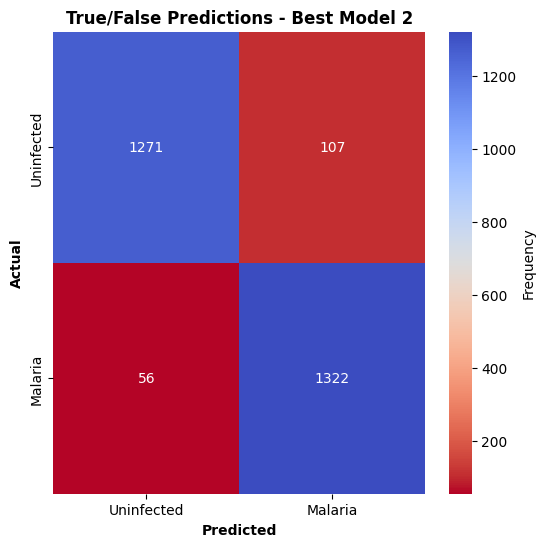

In [35]:
# Plot confusion matrix using seaborn to see labels
plt.figure(figsize=(6, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='coolwarm_r',
            xticklabels=['Uninfected', 'Malaria'], 
            yticklabels=['Uninfected', 'Malaria'],
            cbar_kws={'label': 'Frequency'})
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('True/False Predictions - Best Model 2', fontweight='bold')
plt.show()

MODEL 3 DETAILS
Target Size: 128x128
Batch Size: 256
Data Augmentation used
3 Convolutional Layers 
3 Dense Layers
50% Dropout between each dense layer 

In [36]:
# more complex model, with augmentation, batch_size of 256
train_generator, validation_generator, test_generator = create_data_generators_wholeset(
    base_dir='cell_images',
    target_size=(128,128), 
    batch_size=256,
    augmentation=True)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])



# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


callbacks=[
    EarlyStopping(monitor='val_accuracy', 
                  patience=8, 
                  restore_best_weights=True),
    ModelCheckpoint('best_model_wholeset_v3.h5', 
                    save_best_only=True, 
                    monitor='val_accuracy')
]

# Train the model with augmented data
history_complex_wholeset = model.fit(train_generator, 
                            validation_data=validation_generator, 
                            callbacks=callbacks,
                            epochs=30, 
                            verbose=2)

Found 19291 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Epoch 1/30
76/76 - 301s - loss: 0.5978 - accuracy: 0.7085 - val_loss: 0.3511 - val_accuracy: 0.9160 - 301s/epoch - 4s/step
Epoch 2/30


C:\Users\gdgun\COMP4531\my_tensorflow_project\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 297s - loss: 0.3586 - accuracy: 0.8798 - val_loss: 0.1974 - val_accuracy: 0.9349 - 297s/epoch - 4s/step
Epoch 3/30
76/76 - 309s - loss: 0.2836 - accuracy: 0.9037 - val_loss: 0.1748 - val_accuracy: 0.9358 - 309s/epoch - 4s/step
Epoch 4/30
76/76 - 318s - loss: 0.2561 - accuracy: 0.9136 - val_loss: 0.1632 - val_accuracy: 0.9516 - 318s/epoch - 4s/step
Epoch 5/30
76/76 - 292s - loss: 0.2448 - accuracy: 0.9192 - val_loss: 0.1542 - val_accuracy: 0.9528 - 292s/epoch - 4s/step
Epoch 6/30
76/76 - 283s - loss: 0.2347 - accuracy: 0.9240 - val_loss: 0.1385 - val_accuracy: 0.9572 - 283s/epoch - 4s/step
Epoch 7/30
76/76 - 283s - loss: 0.2224 - accuracy: 0.9264 - val_loss: 0.1415 - val_accuracy: 0.9570 - 283s/epoch - 4s/step
Epoch 8/30
76/76 - 283s - loss: 0.2275 - accuracy: 0.9256 - val_loss: 0.1356 - val_accuracy: 0.9568 - 283s/epoch - 4s/step
Epoch 9/30
76/76 - 280s - loss: 0.2146 - accuracy: 0.9291 - val_loss: 0.1331 - val_accuracy: 0.9566 - 280s/epoch - 4s/step
Epoch 10/30
76/76 - 286s - 

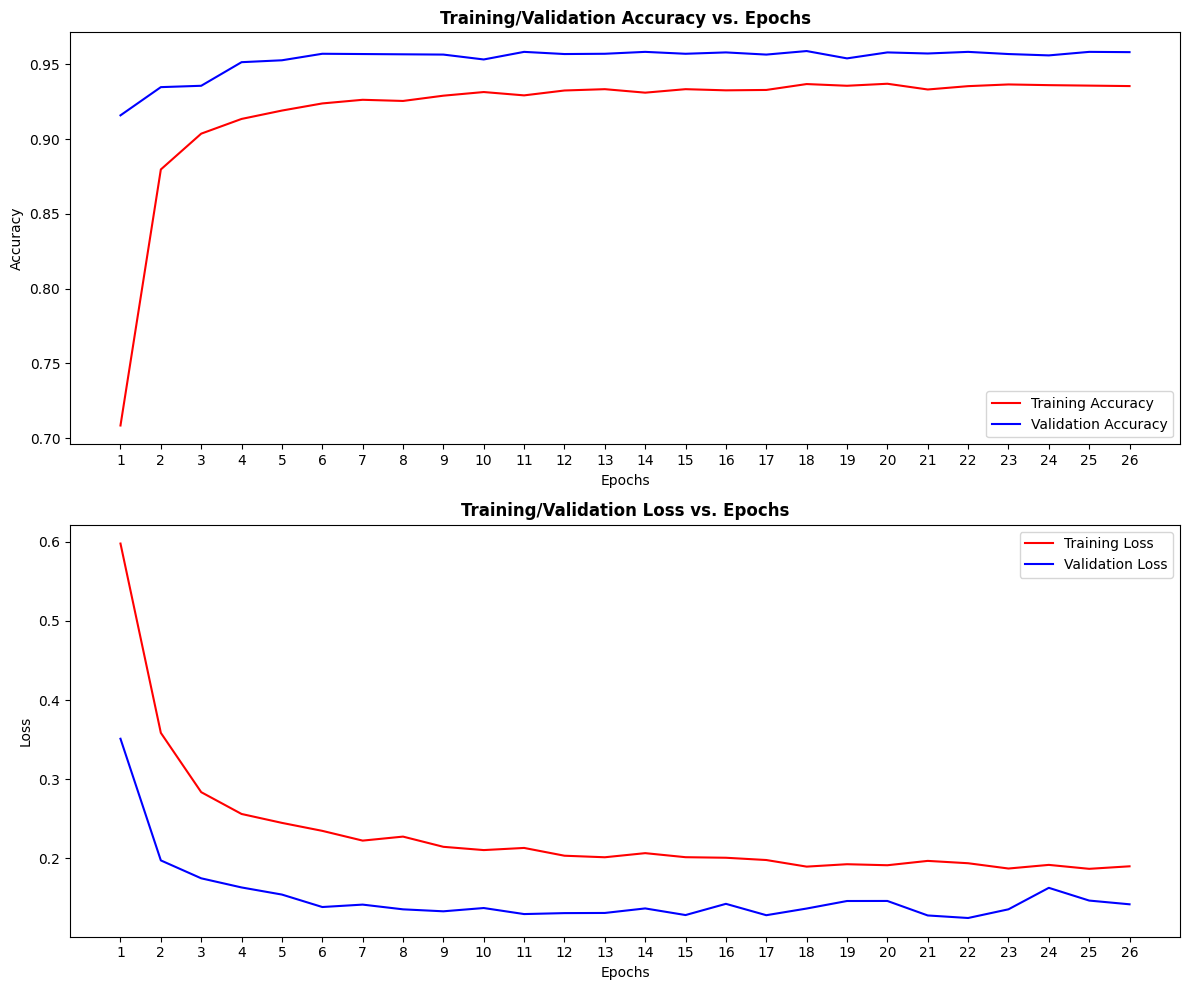

In [37]:
# display plot
plot_acc_loss(history_complex_wholeset)

In [38]:
# Load the best model
best_model_path3 = 'best_model_wholeset_v3.h5'
best_model3 = load_model(best_model_path3)

# Evaluate the model on the test data
test_loss3, test_accuracy3 = best_model3.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss3:.4f}, Test Accuracy: {test_accuracy3:.4f}")

# Make predictions
predictions3 = best_model3.predict(test_generator)
predicted_labels3 = np.round(predictions3).flatten()

# True labels
true_labels3 = test_generator.classes

# check how classes are labeled, before changing 0s and 1s labels
class_indices = test_generator.class_indices
print(f"\nClass Indices: {class_indices}\n")

# Confusion matrix and classification report
cm3 = confusion_matrix(true_labels3, predicted_labels3)
print(f"\nConfusion Matrix:\n{cm3}")

report3 = classification_report(true_labels3, predicted_labels3, 
                                target_names=['Uninfected', 'Malaria'])
print("\nClassification Report:\n", report3)

Test Loss: 0.1091, Test Accuracy: 0.9692
11/11 [==============================] - 6s 546ms/step

Class Indices: {'Uninfected': 0, 'Parasitized': 1}


Confusion Matrix:
[[1339   39]
 [  46 1332]]

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.97      0.97      0.97      1378
     Malaria       0.97      0.97      0.97      1378

    accuracy                           0.97      2756
   macro avg       0.97      0.97      0.97      2756
weighted avg       0.97      0.97      0.97      2756



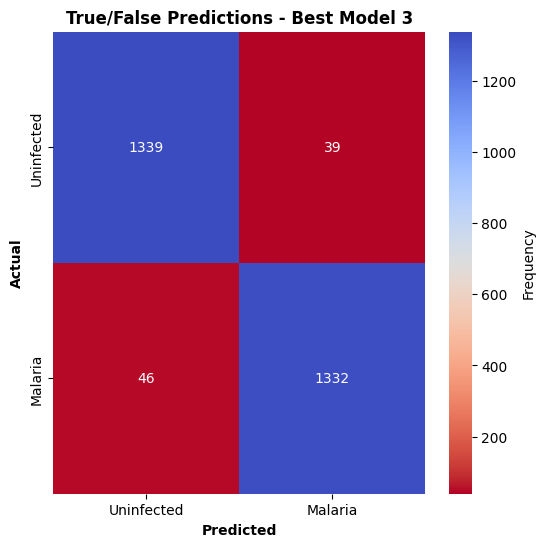

In [39]:
# Plot confusion matrix using seaborn to see labels
plt.figure(figsize=(6, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='coolwarm_r',
            xticklabels=['Uninfected', 'Malaria'], 
            yticklabels=['Uninfected', 'Malaria'],
            cbar_kws={'label': 'Frequency'})
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('True/False Predictions - Best Model 3', fontweight='bold')
plt.show()

MODEL 4 DETAILS
Target Size: 128x128
Batch Size: 256
Data Augmentation used
3 Convolutional Layers 
3 Dense Layers
25% Dropout after each convolutional layer, 50% Dropout between Dense layers
L2 regularization = .001 for each layer (except output layer)
Batch Normalization used on each layer

In [40]:
# adds increased dropout, L2 regularization, and batchnormalization to previous model
train_generator, validation_generator, test_generator = create_data_generators_wholeset(
    base_dir='cell_images',
    target_size=(128,128), 
    batch_size=256,
    augmentation=True)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

callbacks=[
     EarlyStopping(monitor='val_accuracy', 
                   patience=8, 
                   restore_best_weights=True),
     ModelCheckpoint('best_model_wholeset_v4.h5', 
                     save_best_only=True, 
                     monitor='val_accuracy')
]

# Train the model with augmented data
history_complex_bn_wholeset = model.fit(train_generator, 
                            validation_data=validation_generator, 
                            callbacks=callbacks,
                            epochs=30, 
                            verbose=2)

Found 19291 images belonging to 2 classes.
Found 5511 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Epoch 1/30
76/76 - 297s - loss: 1.3760 - accuracy: 0.6001 - val_loss: 1.7548 - val_accuracy: 0.5001 - 297s/epoch - 4s/step
Epoch 2/30


C:\Users\gdgun\COMP4531\my_tensorflow_project\venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


76/76 - 291s - loss: 1.0983 - accuracy: 0.7174 - val_loss: 1.4660 - val_accuracy: 0.5001 - 291s/epoch - 4s/step
Epoch 3/30
76/76 - 285s - loss: 0.8074 - accuracy: 0.8629 - val_loss: 1.7035 - val_accuracy: 0.4999 - 285s/epoch - 4s/step
Epoch 4/30
76/76 - 273s - loss: 0.6764 - accuracy: 0.8923 - val_loss: 1.6902 - val_accuracy: 0.5008 - 273s/epoch - 4s/step
Epoch 5/30
76/76 - 269s - loss: 0.6047 - accuracy: 0.9002 - val_loss: 2.2935 - val_accuracy: 0.5005 - 269s/epoch - 4s/step
Epoch 6/30
76/76 - 283s - loss: 0.5327 - accuracy: 0.9095 - val_loss: 1.3539 - val_accuracy: 0.5041 - 283s/epoch - 4s/step
Epoch 7/30
76/76 - 311s - loss: 0.4910 - accuracy: 0.9123 - val_loss: 1.8973 - val_accuracy: 0.5005 - 311s/epoch - 4s/step
Epoch 8/30
76/76 - 276s - loss: 0.4550 - accuracy: 0.9133 - val_loss: 2.5448 - val_accuracy: 0.5110 - 276s/epoch - 4s/step
Epoch 9/30
76/76 - 281s - loss: 0.4238 - accuracy: 0.9171 - val_loss: 0.4052 - val_accuracy: 0.9318 - 281s/epoch - 4s/step
Epoch 10/30
76/76 - 337s - 

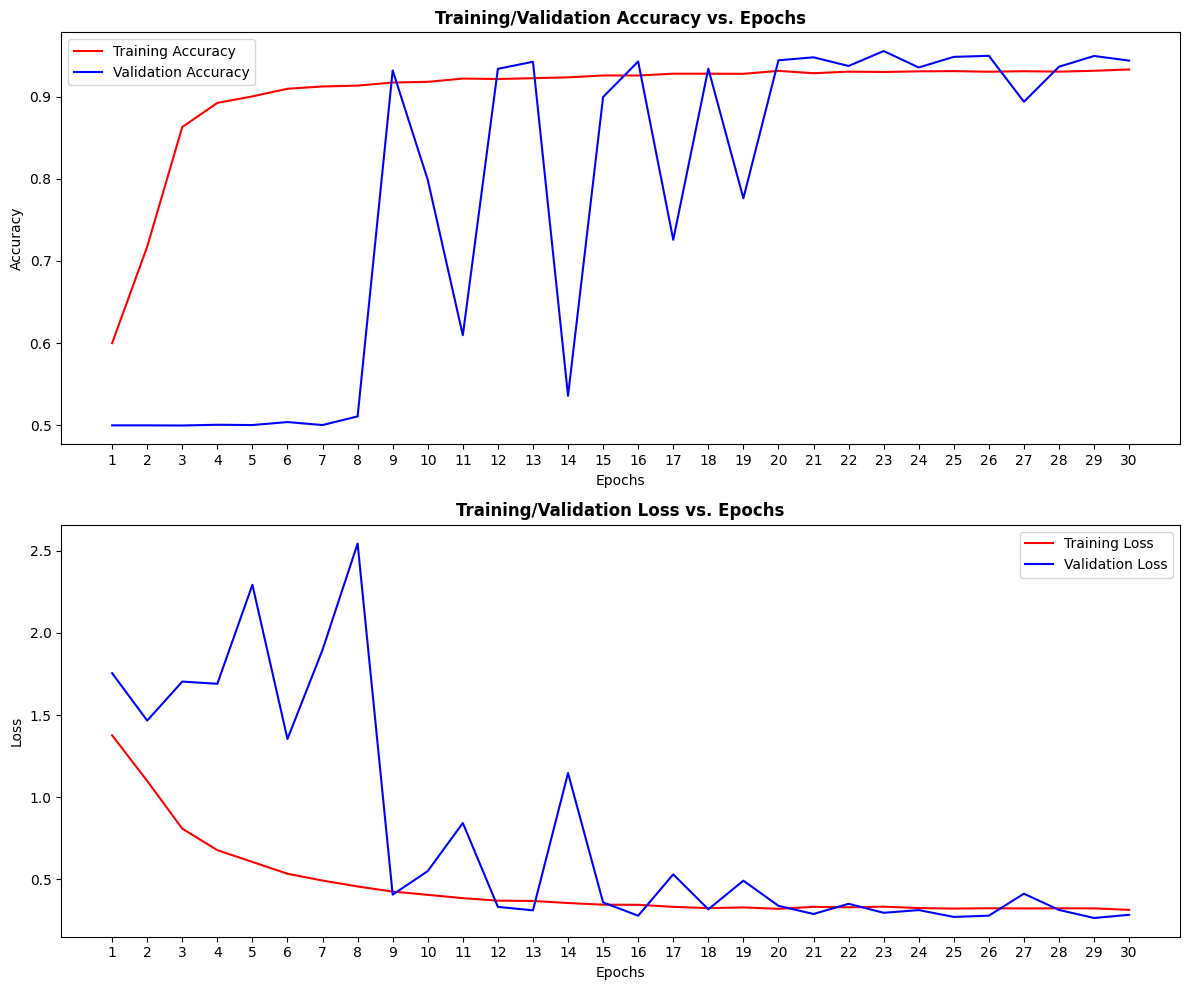

In [41]:
# display plot
plot_acc_loss(history_complex_bn_wholeset)

In [42]:
# Load the best model
best_model_path4 = 'best_model_wholeset_v4.h5'
best_model4 = load_model(best_model_path4)

# Evaluate the model on the test data
test_loss4, test_accuracy4 = best_model4.evaluate(test_generator, verbose=0)
print(f"Test Loss: {test_loss4:.4f}, Test Accuracy: {test_accuracy4:.4f}")

# Make predictions
predictions4 = best_model4.predict(test_generator)
predicted_labels4 = np.round(predictions4).flatten()

# True labels
true_labels4 = test_generator.classes

# check how classes are labeled, before changing 0s and 1s labels
class_indices = test_generator.class_indices
print(f"\nClass Indices: {class_indices}\n")

# Confusion matrix and classification report
cm4 = confusion_matrix(true_labels4, predicted_labels4)
print(f"\nConfusion Matrix:\n{cm4}")

report4 = classification_report(true_labels4, predicted_labels4, 
                                target_names=['Uninfected', 'Malaria'])
print("\nClassification Report:\n", report4)

Test Loss: 0.2798, Test Accuracy: 0.9644
11/11 [==============================] - 13s 1s/step

Class Indices: {'Uninfected': 0, 'Parasitized': 1}


Confusion Matrix:
[[1317   61]
 [  37 1341]]

Classification Report:
               precision    recall  f1-score   support

  Uninfected       0.97      0.96      0.96      1378
     Malaria       0.96      0.97      0.96      1378

    accuracy                           0.96      2756
   macro avg       0.96      0.96      0.96      2756
weighted avg       0.96      0.96      0.96      2756



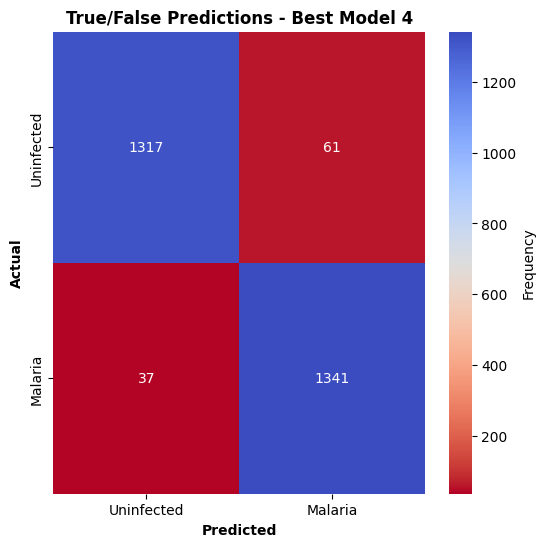

In [43]:
# Plot confusion matrix using seaborn to see labels
plt.figure(figsize=(6, 6))
sns.heatmap(cm4, annot=True, fmt='d', cmap='coolwarm_r',
            xticklabels=['Uninfected', 'Malaria'], 
            yticklabels=['Uninfected', 'Malaria'],
            cbar_kws={'label': 'Frequency'})
plt.ylabel('Actual', fontweight='bold')
plt.xlabel('Predicted', fontweight='bold')
plt.title('True/False Predictions - Best Model 4', fontweight='bold')
plt.show()

Now we will the performance of each of the 4 models that we ran before selecting a final model.

First, we will compare the results of the model.evaluate() function on each of the 4 models.

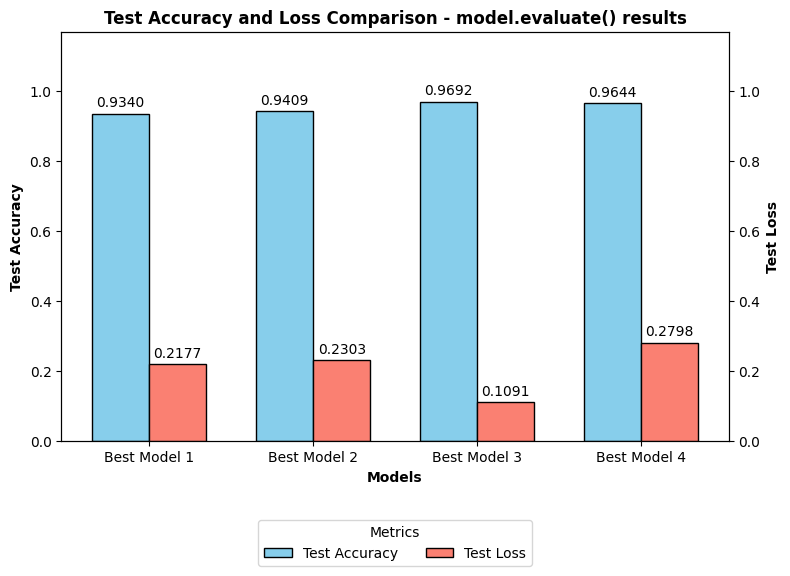

In [44]:
# define accuracies, losses, and names of models
test_accuracies = [test_accuracy1, test_accuracy2, test_accuracy3, test_accuracy4]
test_losses = [test_loss1, test_loss2, test_loss3, test_loss4]
model_names = ['Best Model 1', 'Best Model 2', 'Best Model 3', 'Best Model 4']

x = np.arange(len(model_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot test accuracy
bars1 = ax1.bar(x - width/2, test_accuracies, width, 
                label='Test Accuracy', color='skyblue', edgecolor='black')

# Create a second y-axis for test loss
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, test_losses, width, label='Test Loss', 
                color='salmon', edgecolor='black')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax1.set_xlabel('Models', fontweight='bold')
ax1.set_ylabel('Test Accuracy', fontweight='bold')
ax2.set_ylabel('Test Loss', fontweight='bold')
ax1.set_title('Test Accuracy and Loss Comparison - model.evaluate() results', 
              fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)

# Set both y-axes to the same scale
min_value = 0
max_value = max(max(test_accuracies), max(test_losses))

# Adjust y-axis limits for both ax1 and ax2
ax1.set_ylim(min_value, max_value + .2)
ax2.set_ylim(min_value, max_value + 0.2)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center', 
           bbox_to_anchor=(0.5, -0.25), ncol=2, title='Metrics')

# Add labels
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  
                textcoords="offset points",
                ha='center', va='bottom')

fig.tight_layout()

plt.show()


Based on the results of model.evaluate(), our best performing model appears to be Model 3. It has the highest testing accuracy as well as the lowest testing loss.

Next we will compare the results of the model.predict() function. The function below extracts data from the confusion matrices computer earlier that we want to plot for comparison.

In [45]:
# takes in confusion matrix and outputs precision, recall, and accuracy for plotting
def compute_metrics(cm):
    precision = cm[1][1]/(cm[1][1] + cm[0][1])
    recall = cm[1][1]/(cm[1][1] + cm[1][0])
    accuracy = (cm[1][1] + cm[0][0])/cm.sum()
    
    return precision, recall, accuracy 

# extract metrics for confusion matrices
prec1, rec1, acc1 = compute_metrics(cm1)
prec2, rec2, acc2 = compute_metrics(cm2)
prec3, rec3, acc3 = compute_metrics(cm3)
prec4, rec4, acc4 = compute_metrics(cm4)

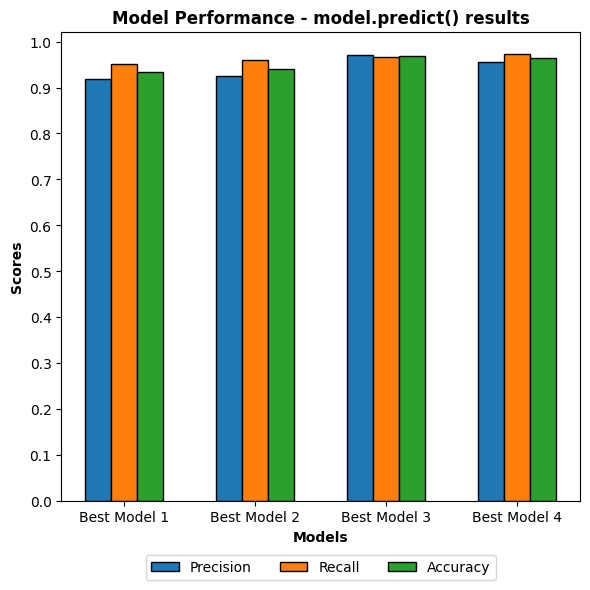


Prediction Metrics Table:
╒══════════════╤═════════════╤══════════╤════════════╕
│              │   Precision │   Recall │   Accuracy │
╞══════════════╪═════════════╪══════════╪════════════╡
│ Best Model 1 │      0.9194 │   0.9514 │     0.934  │
├──────────────┼─────────────┼──────────┼────────────┤
│ Best Model 2 │      0.9251 │   0.9594 │     0.9409 │
├──────────────┼─────────────┼──────────┼────────────┤
│ Best Model 3 │      0.9716 │   0.9666 │     0.9692 │
├──────────────┼─────────────┼──────────┼────────────┤
│ Best Model 4 │      0.9565 │   0.9731 │     0.9644 │
╘══════════════╧═════════════╧══════════╧════════════╛


In [46]:
# Metrics for each group
precisions = [prec1, prec2, prec3, prec4]
recalls = [rec1, rec2, rec3, rec4]
accuracies = [acc1, acc2, acc3, acc4]

# Labels for each group
labels = ['Best Model 1', 'Best Model 2', 'Best Model 3', 'Best Model 4']

x = np.arange(len(labels))  
width = 0.2

fig, ax = plt.subplots(figsize=(6, 6))

# Plotting the bars for each metric
rects1 = ax.bar(x - width, precisions, width, 
                label='Precision', edgecolor='black')
rects2 = ax.bar(x, recalls, width, 
                label='Recall', edgecolor='black')
rects3 = ax.bar(x + width, accuracies, width, 
                label='Accuracy', edgecolor='black')

# Adding labels and title
ax.set_ylabel('Scores', fontweight='bold')
ax.set_yticks(np.arange(0, 1.1, .1))
ax.set_xlabel('Models', fontweight='bold')
ax.set_title('Model Performance - model.predict() results', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

fig.tight_layout()
plt.show()


# display a table of the results 
predict_metrics = {
    'Model': labels,
    'Precision': np.round(precisions,4),
    'Recall': np.round(recalls,4),
    'Accuracy': np.round(accuracies,4)
}

# Create a DataFrame
df_metrics = pd.DataFrame(predict_metrics)
df_metrics.set_index('Model', inplace=True)

# bold headers and indices
headers = [f'\033[1m{header}\033[0m' for header in df_metrics.columns]
index = [f'\033[1m{idx}\033[0m' for idx in df_metrics.index]

# fancy grid with tabulate
print('\nPrediction Metrics Table:')
print(tabulate(df_metrics, headers=headers, 
               tablefmt='fancy_grid',showindex=index))


In [47]:
# model with best precision
best_prec = np.max(df_metrics['Precision'])
best_prec_model = df_metrics[df_metrics['Precision']==best_prec].index[0]

# model with best recall
best_rec = np.max(df_metrics['Recall'])
best_rec_model = df_metrics[df_metrics['Recall']==best_rec].index[0]

# model with best accuracy
best_acc = np.max(df_metrics['Accuracy'])
best_acc_model = df_metrics[df_metrics['Accuracy']==best_acc].index[0]

# print results 
print(f'Highest Precision - {best_prec_model}: {best_prec}')
print(f'Highest Recall - {best_rec_model}: {best_rec}')
print(f'Highest Accuracy - {best_acc_model}: {best_acc}')

Highest Precision - Best Model 3: 0.9716
Highest Recall - Best Model 4: 0.9731
Highest Accuracy - Best Model 3: 0.9692


We may want to modify the threshold at which a prediction is converted to a 0 or 1. In this case for instance, falsely classifing an image as 'Uninfected' when in fact the image was taken from a patient with Malaria, could have drastic consequences (depending on the application of the model). A person infected with Malaria may not be given the early care they need in order to survive if they are falsely diagnosed as healthy. In our case, we will assume False negatives would have far worse effects than False Positives. Particularly if positive results are re-verified using traditional methods.

Because the ultimate goal of our model is to minimize deaths caused by Malaria, we may be willing to sacrifice some model accuracy in order to increase the recall of the model. The recall of the model measures how well the model predicts instances of Malaria from the total number of actual instances of Malaria. Higher recall means less False negatives diagnoses. 

Now that we have our highest performing model (model 3), we can modify the classification theshold at which the output probability is converted to a positive ('Malaria') prediction. 

By default, the classification threshold is .5 in a binary classification model. Predictions greater than .5 are converted to 1s and predictions less than .5 are converted to 0s. By lowering the classification threshold, we will increase the amount of positive ('Malaria') predictions. This will increase the amount of False Positives and decrease the amount of False Negatives.

11/11 [==============================] - 10s 859ms/step


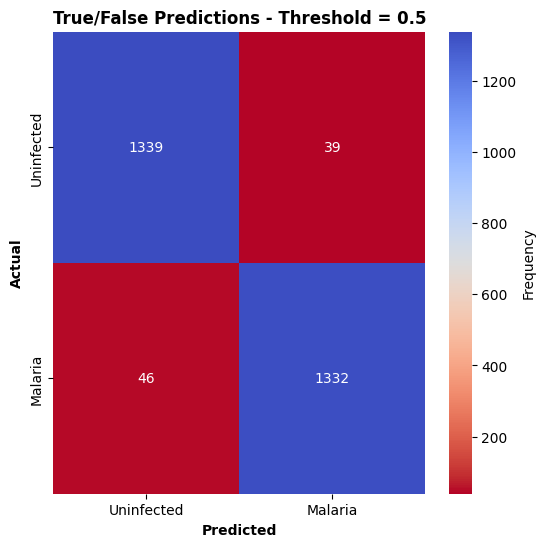

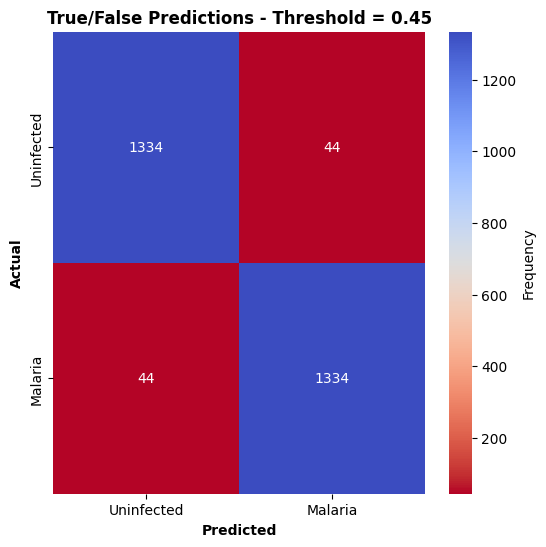

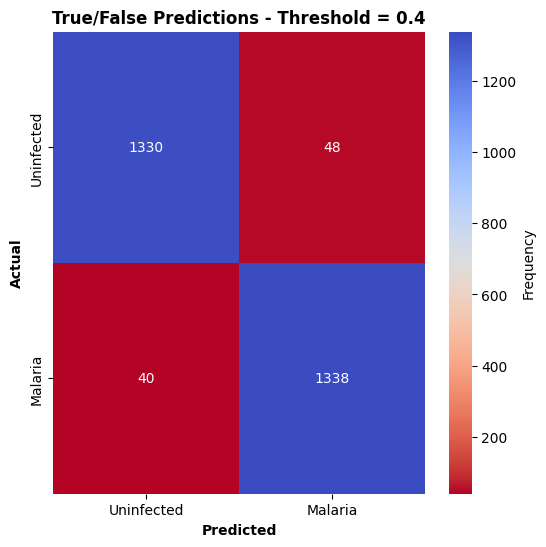

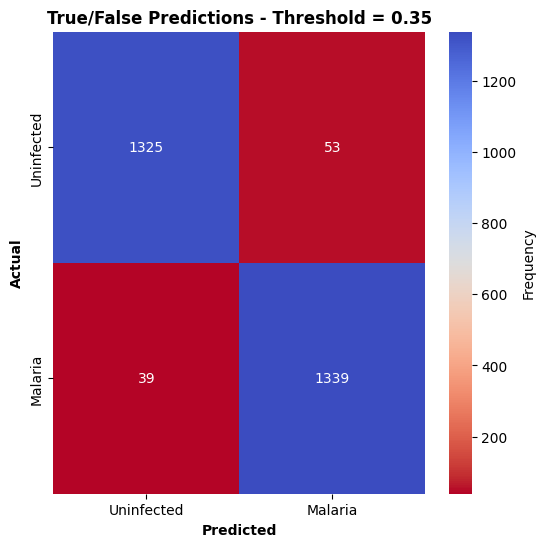

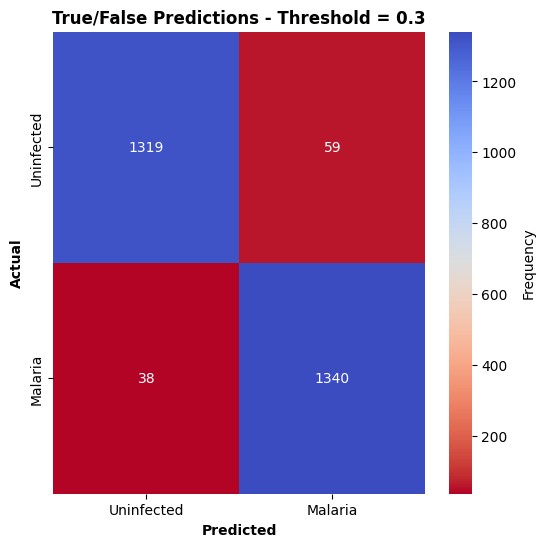

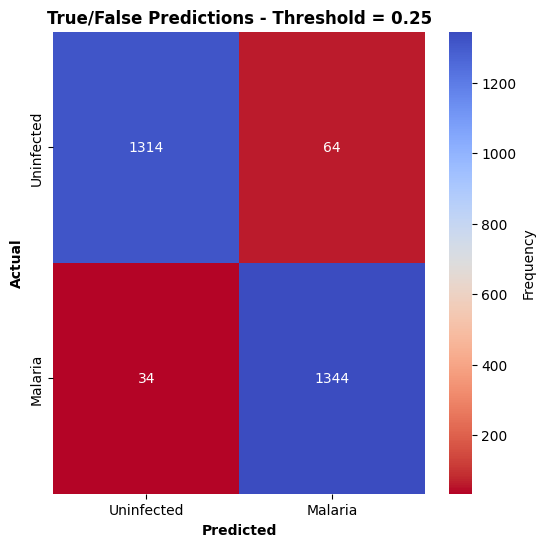

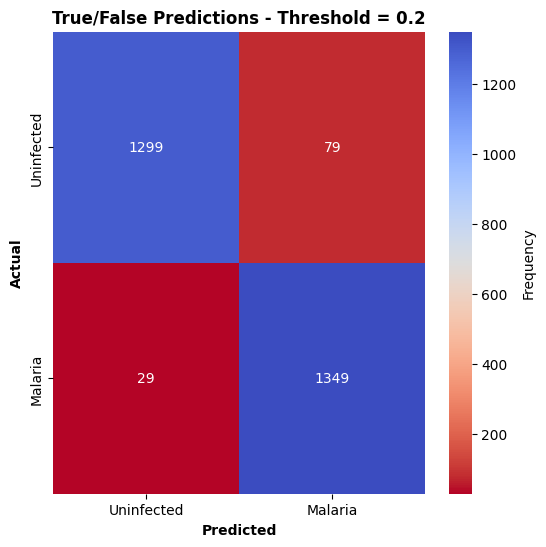

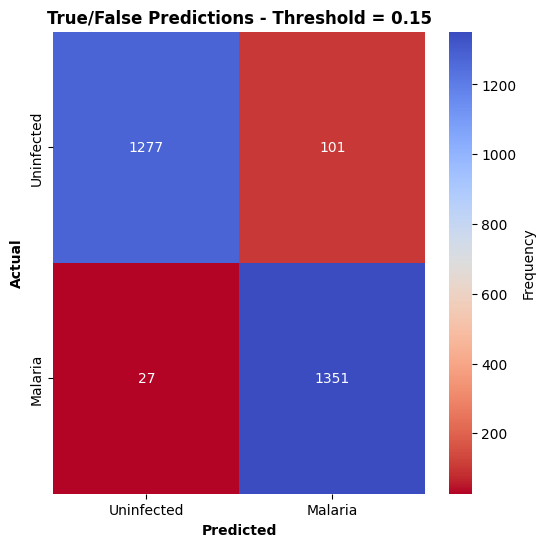

In [48]:
# Load model with highest accuracy
best_model_path = 'best_model_wholeset_v3.h5'
best_model = load_model(best_model_path)

# Make predictions
predictions = best_model.predict(test_generator)

# define a list of different thresholds
thresholds = [0.50, 0.45, 0.40, 0.35, 0.30, 0.25, .20, .15]

thresholds_dict = {}
for threshold in thresholds:
    # generate predictions based on each threshold
    predicted_labels = (predictions > threshold).astype(int).flatten()
    
    # True labels
    true_labels = test_generator.classes
    
    # Compute metrics
    cm = confusion_matrix(true_labels, predicted_labels)
   
    # Store results in dictionary
    thresholds_dict[threshold] = cm

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm_r',
                xticklabels=['Uninfected', 'Malaria'], 
                yticklabels=['Uninfected', 'Malaria'],
                cbar_kws={'label': 'Frequency'})
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.title(f'True/False Predictions - Threshold = {threshold}', fontweight='bold')
    plt.show()

In [49]:
# compute recall from each modified threshold
prec_50, rec_50, acc_50 = compute_metrics(thresholds_dict[.50])
prec_45, rec_45, acc_45 = compute_metrics(thresholds_dict[.45])
prec_40, rec_40, acc_40 = compute_metrics(thresholds_dict[.40])
prec_35, rec_35, acc_35 = compute_metrics(thresholds_dict[.35])
prec_30, rec_30, acc_30 = compute_metrics(thresholds_dict[.30])
prec_25, rec_25, acc_25 = compute_metrics(thresholds_dict[.25])
prec_20, rec_20, acc_20 = compute_metrics(thresholds_dict[.20])
prec_15, rec_15, acc_15 = compute_metrics(thresholds_dict[.15])

prec_list = [prec_50, prec_45, prec_40, prec_35, prec_30, prec_25, prec_20, prec_15]
rec_list = [rec_50, rec_45, rec_40, rec_35, rec_30, rec_25, rec_20, rec_15]
acc_list = [acc_50, acc_45, acc_40, acc_35, acc_30, acc_25, acc_20, acc_15]

# print out model recall for each threshold
for thresh, rec in zip(thresholds, rec_list):
    print(f'Classification Threshold {thresh}: Recall = {np.round(rec,4)}')

# display a table of the results 
threshold_metrics = {
    'Threshold': thresholds,
    'Precision': np.round(prec_list,4),
    'Recall': np.round(rec_list,4),
    'Accuracy': np.round(acc_list,4)
}

# Create a DataFrame
threshold_metrics = pd.DataFrame(threshold_metrics)
threshold_metrics.set_index('Threshold', inplace=True)

# bold headers and indices
headers = [f'\033[1m{header}\033[0m' for header in threshold_metrics.columns]
index = [f'\033[1m{idx}\033[0m' for idx in threshold_metrics.index]

# fancy grid using tabulate
print('\nThreshold Metrics Table - Best Model 3:')
print(tabulate(threshold_metrics, headers=headers, 
               tablefmt='fancy_grid',showindex=index))

Classification Threshold 0.5: Recall = 0.9666
Classification Threshold 0.45: Recall = 0.9681
Classification Threshold 0.4: Recall = 0.971
Classification Threshold 0.35: Recall = 0.9717
Classification Threshold 0.3: Recall = 0.9724
Classification Threshold 0.25: Recall = 0.9753
Classification Threshold 0.2: Recall = 0.979
Classification Threshold 0.15: Recall = 0.9804

Threshold Metrics Table - Best Model 3:
╒══════╤═════════════╤══════════╤════════════╕
│      │   Precision │   Recall │   Accuracy │
╞══════╪═════════════╪══════════╪════════════╡
│ 0.5  │      0.9716 │   0.9666 │     0.9692 │
├──────┼─────────────┼──────────┼────────────┤
│ 0.45 │      0.9681 │   0.9681 │     0.9681 │
├──────┼─────────────┼──────────┼────────────┤
│ 0.4  │      0.9654 │   0.971  │     0.9681 │
├──────┼─────────────┼──────────┼────────────┤
│ 0.35 │      0.9619 │   0.9717 │     0.9666 │
├──────┼─────────────┼──────────┼────────────┤
│ 0.3  │      0.9578 │   0.9724 │     0.9648 │
├──────┼─────────────┼───

I was surprised to find that the different classification thresholds did not have a large effect on the output predictions. The lower threshold predictions did make more predictions for Malaria but only slightly more. For instance, the lowest threshold model of .15 only predicted 71 more instances of Malaria than the highest threshold model of .50 (threshold = .15 predicted 1444 Malaria instances, threshold = .50 predicted 1371 Malaria instances). Model recall was increased, but not as much as I initially expected. The increase in model recall came at the cost of precision/accuracy as shown in the table above. 

These puzzling results are likely the result of our model making very confident predictions. For instance of the model was generating outputs that were almost always < .1 or greater than .9, the modified thresholds would not have a very large effect. 

We can create a scatterplot of the predicted probabilities to see if this is the case. 

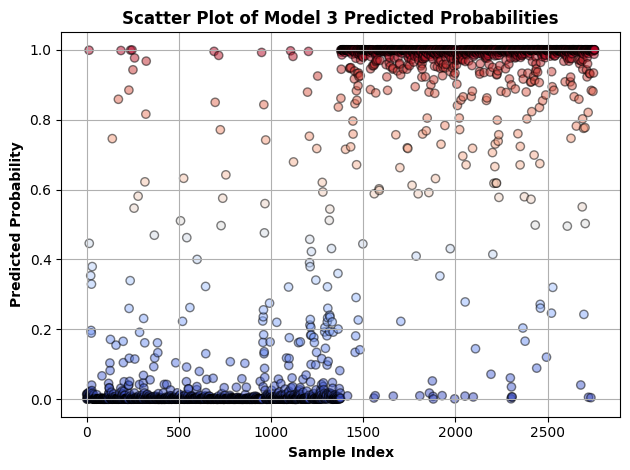

In [50]:
# define x,y
pred_probs = predictions.flatten()
indices = np.arange(len(pred_probs))

# create scatterlot of output probs of Model 3
plt.scatter(indices, pred_probs, c=pred_probs, cmap='coolwarm', 
            alpha=.5, edgecolor='k')
plt.title('Scatter Plot of Model 3 Predicted Probabilities', fontweight='bold')
plt.xlabel('Sample Index', fontweight='bold')
plt.ylabel('Predicted Probability', fontweight='bold')

plt.grid(True)
plt.tight_layout()
plt.show()

Based on the scatterplot, the vast majority of the predictions are made with great confidence. This is why modifying our classification threshold had little effect. 

Results:

The model that performed the best after validation and testing was the third model trained on the entire dataset 'best_model_wholeset_v3.h5'. This model had the highest accuracy (.9655) and highest recall (.963) when making predictions on the previously unseen testing data. 

The architecture of Model 3 was as follows:
MODEL 3 DETAILS Target Size: 128x128 Batch Size: 256 Data Augmentation used 3 Convolutional Layers 3 Dense Layers 50% Dropout between each dense layer

Depending on the applicaiton of this model, if minimizing False negatives is the utmost priority, then the classification threshold can be lowered. This will come at the cost of precision and likely accuracy. 